In [1]:
import EOSutils as meos

import numpy as np
import matplotlib.pyplot as plt

import matplotlib.style
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.style.use('classic')

from astropy.table import Table
from astropy import units as u
from astropy.constants import G

from decimal import Decimal

import mesa_helper as mh
import os
import shutil
import copy
import time
import warnings

from scipy import ndimage, interpolate, optimize
from scipy.integrate import quad
import pickle

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# As far as I understand it, the proper way to use the CD21 tables for arbitrary H/He mixtures is to take their
# "effective H" table and combine it with the CMS19 He table using the additive volume law. 
# Let's see if I can reproduce their Y=0.245 table this way.

In [3]:
# note that we're working directly with TP tables, not Trho tables
cd21_H = meos.CMStable("./2021_chabrier+_tables/TABLE_H_TP_effective",units='cgs')
cd21_He = meos.CMStable("./2021_chabrier+_tables/TABLE_HE_TP_v1",units='cgs')
cd21_Y0275 = meos.CMStable("./2021_chabrier+_tables/TABLEEOS_2021_TP_Y0275_v1",units='cgs')

In [4]:
cd21_H_attr_list = dir(cd21_H)

cd21_H_attr_list_filtered = []
for i, li in enumerate(cd21_H_attr_list):
    if li[0] != "_":
        cd21_H_attr_list_filtered.append(li)
        
print(cd21_H_attr_list_filtered)

['Cp', 'Cv', 'X', 'Y', 'atomic_number', 'chiRho', 'chiT', 'dE_drho_T', 'dE_drho_T_direct', 'dS_dT_rho', 'dS_dT_rho_direct', 'dS_drho_T', 'dS_drho_T_direct', 'dlE_dlrho_T', 'dlS_dlP_T_grid', 'dlS_dlT_P_grid', 'dlS_dlT_rho', 'dlS_dlrho_T', 'dlrho_dlP_T_grid', 'dlrho_dlT_P_grid', 'eosData', 'eta', 'filename', 'gamma1', 'gamma3', 'grad_ad', 'grad_ad_grid', 'independent_arr_1', 'independent_arr_2', 'independent_var_1', 'independent_var_2', 'log10Pgrid', 'log10Sgrid', 'log10Tgrid', 'log10Ugrid', 'log10rhogrid', 'log_free_e', 'mass_number', 'mu', 'units']


In [12]:
class simple_table(object):
    def __init__(self, units='cgs', **kwargs):
        if units == 'cms' or units == 'cgs' or units == 'CMS':
            self.units = units
        else: 
            print('units must be cgs or mks or CMS (T [K], P [GPa], rho [g/cm^3], U [MJ/kg], S [MJ/kg/K])')

        self.X = None
        self.Y = None
        
        self.atomic_number = None
        self.mass_number = None

        self.log10Tgrid = None
        self.log10Pgrid = None
        self.log10rhogrid = None
        self.log10Sgrid = None
        self.log10Ugrid = None

In [14]:
def add_mixing_terms_CD21(H_PTtable, He_PTtable, Z_PTtable=None, X=0.725, Y=0.275):
    """
    Mix tables using additive volume law only, as I think is intended for CD21. 
    
    Assumes that all input tables are evaluated on the same P, T grid, and that
    the grid coordinates are
    
    Tarr=np.arange(2.,8.04,0.05) 
    Parr=np.arange(1.0,23.04,0.05)

    1/rho_mix = X/rho_H + Y/rho_He +
    S_mix = X*S_H + Y*S_He + X*Y*S_mix
    E_mix = X*E_H + Y*E_He
    """

    Z = 1. - (X + Y)

    shared_log10Tgrid = H_PTtable.log10Tgrid
    shared_log10Pgrid = H_PTtable.log10Pgrid

    mixed_table = simple_table()
    mixed_table.X = X
    mixed_table.Y = Y
    mixed_table.log10Tgrid = shared_log10Tgrid
    mixed_table.log10Pgrid = shared_log10Pgrid

    mixed_log10rhogrid = np.zeros_like(shared_log10Tgrid)
    mixed_log10Sgrid = np.zeros_like(shared_log10Tgrid)
    mixed_log10Ugrid = np.zeros_like(shared_log10Tgrid)

    Tarr = np.arange(2.,8.04,0.05)
    Parr = np.arange(1.0,23.04,0.05)

    for i, P in enumerate(Parr):
        Pround = np.round(P,2)

        for j, T in enumerate(Tarr):
            Tround = np.round(T,2)

            rho_H = 10**H_PTtable.log10rhogrid[i,j]
            rho_He = 10**He_PTtable.log10rhogrid[i,j]

            S_H = 10**H_PTtable.log10Sgrid[i,j]
            S_He = 10**He_PTtable.log10Sgrid[i,j]

            U_H = 10**H_PTtable.log10Ugrid[i,j]
            U_He = 10**He_PTtable.log10Ugrid[i,j]

            if Z_PTtable is None:
                mixed_log10rhogrid[i,j] = np.log10(1./((X/rho_H) + (Y/rho_He)))
                mixed_log10Sgrid[i,j] = np.log10(X*S_H + Y*S_He)
                mixed_log10Ugrid[i,j] = np.log10(X*U_H + Y*U_He)
                
            else:
                rho_Z = 10**Z_PTtable.log10rhogrid[i,j]
                S_Z = 10**Z_PTtable.log10Sgrid[i,j]
                U_Z = 10**Z_PTtable.log10Ugrid[i,j]
                
                mixed_log10rhogrid[i,j] = np.log10(1./((X/rho_H) + (Y/rho_He) + (Z/rho_Z)))
                mixed_log10Sgrid[i,j] = np.log10(X*S_H + Y*S_He + Z*S_Z)
                mixed_log10Ugrid[i,j] = np.log10(X*U_H + Y*U_He + Z*U_Z)
    
    mixed_table.log10rhogrid = mixed_log10rhogrid
    mixed_table.log10Sgrid = mixed_log10Sgrid
    mixed_table.log10Ugrid = mixed_log10Ugrid
    
    return mixed_table
    


In [59]:
test_cd21_Y0275 = add_mixing_terms_CD21(H_PTtable=cd21_H, He_PTtable=cd21_He, Z_PTtable=None, X=0.725, Y=0.275)
print(test_cd21_Y0275.log10Sgrid[~np.isfinite(test_cd21_Y0275.log10Sgrid)])
print(test_cd21_Y0275.log10Ugrid[~np.isfinite(test_cd21_Y0275.log10Ugrid)])

# get rid of infs
test_cd21_Y0275.log10Sgrid[~np.isfinite(test_cd21_Y0275.log10Sgrid)] = np.max(test_cd21_Y0275.log10Sgrid[np.isfinite(test_cd21_Y0275.log10Sgrid)])
test_cd21_Y0275.log10Ugrid[~np.isfinite(test_cd21_Y0275.log10Ugrid)] = np.max(test_cd21_Y0275.log10Ugrid[np.isfinite(test_cd21_Y0275.log10Ugrid)])

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_96290/1611894132.py:43: RuntimeWarning: overflow encountered in scalar power
  S_H = 10**H_PTtable.log10Sgrid[i,j]
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_96290/1611894132.py:46: RuntimeWarning: overflow encountered in scalar power
  U_H = 10**H_PTtable.log10Ugrid[i,j]
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_96290/1611894132.py:47: RuntimeWarning: overflow encountered in scalar power
  U_He = 10**He_PTtable.log10Ugrid[i,j]


[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf]
[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf]


/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_96290/1611894132.py:44: RuntimeWarning: overflow encountered in scalar power
  S_He = 10**He_PTtable.log10Sgrid[i,j]


In [60]:
print(np.min(cd21_H.log10rhogrid))
print(np.max(cd21_H.log10rhogrid))
print(np.min(test_cd21_Y0275.log10rhogrid))
print(np.max(test_cd21_Y0275.log10rhogrid))
print(np.min(cd21_He.log10rhogrid))
print(np.max(cd21_He.log10rhogrid))
print("")
print(np.min(cd21_H.log10Sgrid))
print(np.max(cd21_H.log10Sgrid))
print(np.min(test_cd21_Y0275.log10Sgrid))
print(np.max(test_cd21_Y0275.log10Sgrid))
print(np.min(cd21_He.log10Sgrid))
print(np.max(cd21_He.log10Sgrid))
print("")
print(np.min(cd21_H.log10Ugrid))
print(np.max(cd21_H.log10Ugrid))
print(np.min(test_cd21_Y0275.log10Ugrid))
print(np.max(test_cd21_Y0275.log10Ugrid))
print(np.min(cd21_He.log10Ugrid))
print(np.max(cd21_He.log10Ugrid))


-9.0
6.09124
-9.0
6.153788559061849
-9.0
6.4666

-116.259
7304.27
1.7433780065709932
281.8293326938302
-16.7654
366.637

-207.58
31741.9
9.57772473173982
307.223338006571
-28.3358
441.933


/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_96290/2896652320.py:2: RuntimeWarning: divide by zero encountered in log10
  rho_diff = np.log10(np.abs(10**cd21_Y0275.log10rhogrid - 10**test_cd21_Y0275.log10rhogrid))
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_96290/2896652320.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))


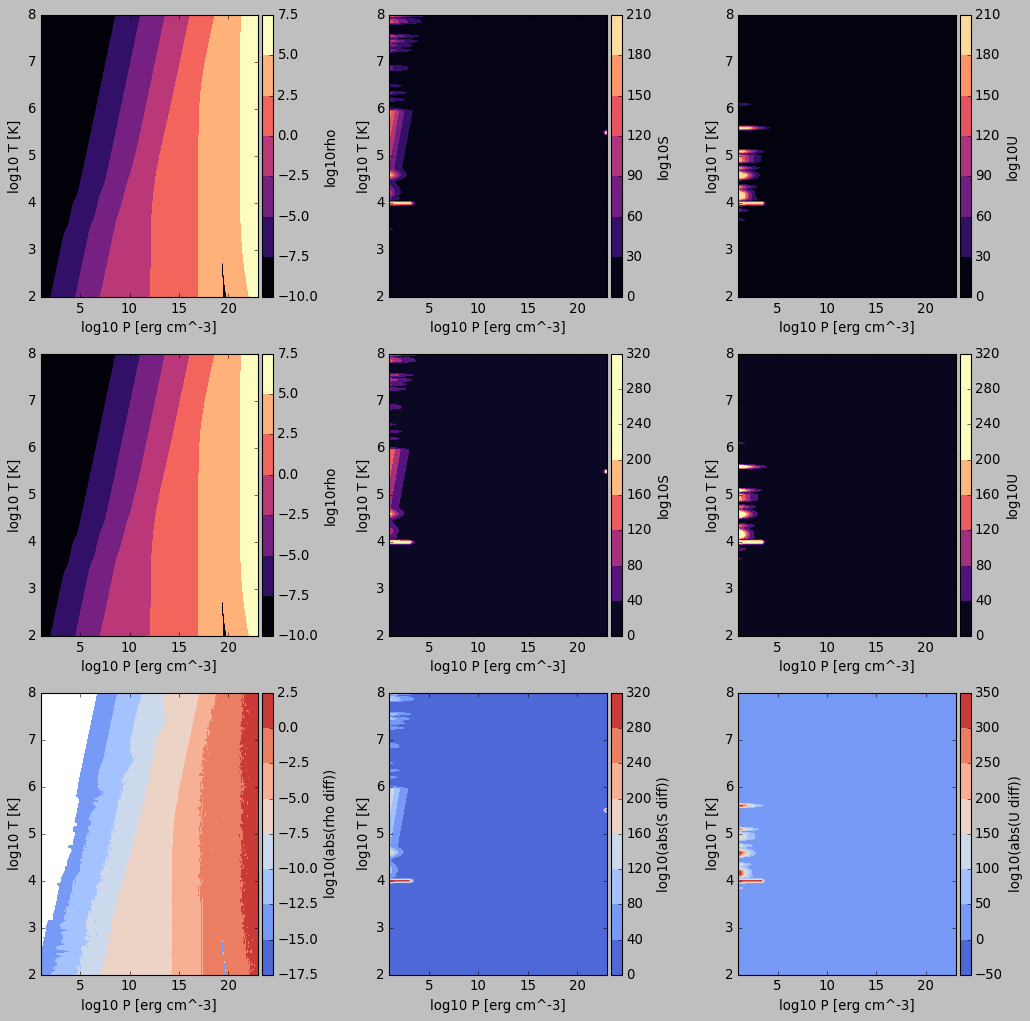

In [55]:
# plot differences between CD21-provided Y=0.275 table and the one I just calculated
rho_diff = np.log10(np.abs(10**cd21_Y0275.log10rhogrid - 10**test_cd21_Y0275.log10rhogrid))
S_diff = np.log10(np.abs(10**cd21_Y0275.log10Sgrid - 10**test_cd21_Y0275.log10Sgrid))
U_diff = np.log10(np.abs(10**cd21_Y0275.log10Ugrid - 10**test_cd21_Y0275.log10Ugrid))

cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
cmap.set_over('red')
cmap.set_under('black')
cmap.set_bad('grey')


fig, axes = plt.subplots(3,3,figsize=(15,15))
# CD21-provided Y=0.275 table
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contourf(cd21_Y0275.log10Pgrid, cd21_Y0275.log10Tgrid, cd21_Y0275.log10rhogrid, cmap='magma',vmin=-9,vmax=6.2)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='log10rho')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contourf(cd21_Y0275.log10Pgrid, cd21_Y0275.log10Tgrid, cd21_Y0275.log10Sgrid, cmap='magma',vmin=7,vmax=210)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='log10S')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contourf(cd21_Y0275.log10Pgrid, cd21_Y0275.log10Tgrid, cd21_Y0275.log10Ugrid, cmap='magma',vmin=9,vmax=210)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='log10U')

# my Y=0.275 table
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contourf(cd21_Y0275.log10Pgrid, cd21_Y0275.log10Tgrid, test_cd21_Y0275.log10rhogrid, cmap='magma',vmin=-9,vmax=6.2)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='log10rho')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contourf(cd21_Y0275.log10Pgrid, cd21_Y0275.log10Tgrid, test_cd21_Y0275.log10Sgrid, cmap='magma',vmin=7,vmax=210)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='log10S')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
cs12 = axes[1,2].contourf(cd21_Y0275.log10Pgrid, cd21_Y0275.log10Tgrid, test_cd21_Y0275.log10Ugrid, cmap='magma',vmin=9,vmax=210)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='log10U')

# diff
divider20 = make_axes_locatable(axes[2,0])
cax20 = divider20.append_axes('right', size='5%', pad=0.05)
cs20 = axes[2,0].contourf(cd21_Y0275.log10Pgrid, cd21_Y0275.log10Tgrid, rho_diff, cmap=cmap,)
fig.colorbar(cs20, cax=cax20, orientation='vertical',label='log10(abs(rho diff))')

divider21 = make_axes_locatable(axes[2,1])
cax21 = divider21.append_axes('right', size='5%', pad=0.05)
cs21 = axes[2,1].contourf(cd21_Y0275.log10Pgrid, cd21_Y0275.log10Tgrid, S_diff, cmap=cmap,)
fig.colorbar(cs21, cax=cax21, orientation='vertical',label='log10(abs(S diff))')

divider22 = make_axes_locatable(axes[2,2])
cax22 = divider22.append_axes('right', size='5%', pad=0.05)
cs22 = axes[2,2].contourf(cd21_Y0275.log10Pgrid, cd21_Y0275.log10Tgrid, U_diff, cmap=cmap, )
fig.colorbar(cs22, cax=cax22, orientation='vertical',label='log10(abs(U diff))')

for ax in np.ravel(axes):
    ax.set_xlim(1.,23.)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 P [erg cm^-3]')
    ax.set_ylabel('log10 T [K]')
    
plt.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
Plevels = np.linspace(1.,30., 100)
Pvmin = 1
Pvmax = 23.0

Slevels = np.linspace(2., 16., 200)
Svmin = 2
Svmax = 10.5

Ulevels = np.linspace(9., 30., 100)
Uvmin = 9.
Uvmax = 23.0

diffvmin = -10
diffvmax = -0.5
difflevels = np.linspace(diffvmin,0,6)


fig, axes = plt.subplots(3,3,figsize=(15,15))

# row 0: original CMS
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contourf(cms_H.log10rhogrid, cms_H.log10Tgrid, cms_H.log10Pgrid, levels=Plevels, cmap='magma',alpha=1,vmin=Pvmin, vmax=Pvmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='log10 P')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contourf(cms_H.log10rhogrid, cms_H.log10Tgrid, cms_H.log10Sgrid, levels=Slevels, cmap='magma',alpha=1,vmin=Svmin, vmax=Svmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='log10 S')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contourf(cms_H.log10rhogrid, cms_H.log10Tgrid, cms_H.log10Ugrid, levels=Ulevels, cmap='magma',alpha=1,vmin=Uvmin, vmax=Uvmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='log10 U')

# row 1: blend
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contourf(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.log10Pgrid, levels=Plevels, cmap='magma',alpha=1,vmin=Pvmin, vmax=Pvmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='log10 P')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contourf(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.log10Sgrid, levels=Slevels, cmap='magma',alpha=1,vmin=Svmin, vmax=Svmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='log10 S')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
cs12 = axes[1,2].contourf(cms_H.log10rhogrid, bln_H.log10Tgrid, bln_H.log10Ugrid, levels=Ulevels, cmap='magma',alpha=1,vmin=Uvmin, vmax=Uvmax)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='log10 U')


log10P_reldiff = np.log10(np.abs((cms_H.log10Pgrid - bln_H.log10Pgrid)/cms_H.log10Pgrid))
log10S_reldiff = np.log10(np.abs((cms_H.log10Sgrid - bln_H.log10Sgrid)/cms_H.log10Sgrid))
log10U_reldiff = np.log10(np.abs((cms_H.log10Ugrid - bln_H.log10Ugrid)/cms_H.log10Ugrid))

# row 2: finite diff
divider20 = make_axes_locatable(axes[2,0])
cax20 = divider20.append_axes('right', size='5%', pad=0.05)
cs20 = axes[2,0].contourf(cms_H.log10rhogrid, cms_H.log10Tgrid, log10P_reldiff, levels=difflevels, cmap='plasma',alpha=1,vmin=diffvmin, vmax=diffvmax)
fig.colorbar(cs20, cax=cax20, orientation='vertical',label='log10(relative difference in log10P)')

divider21 = make_axes_locatable(axes[2,1])
cax21 = divider21.append_axes('right', size='5%', pad=0.05)
cs21 = axes[2,1].contourf(cms_H.log10rhogrid, cms_H.log10Tgrid, log10S_reldiff, levels=difflevels, cmap='plasma',alpha=1,vmin=diffvmin, vmax=diffvmax)
fig.colorbar(cs21, cax=cax21, orientation='vertical',label='log10(relative difference in log10S)')

divider22 = make_axes_locatable(axes[2,2])
cax22 = divider22.append_axes('right', size='5%', pad=0.05)
cs22 = axes[2,2].contourf(cms_H.log10rhogrid, cms_H.log10Tgrid, log10U_reldiff, levels=difflevels, cmap='plasma',alpha=1,vmin=diffvmin, vmax=diffvmax)
fig.colorbar(cs22, cax=cax22, orientation='vertical',label='log10(relative difference in log10U)')

for ax in np.ravel(axes):
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')

axes[0,0].set_title("CMS19")

axes[1,0].set_title("Maz22/CMS19 blend")
axes[2,0].set_title("finite diff")
plt.subplots_adjust(wspace=0.5)
#plt.show()

# Mixture tables

In [49]:
# for mixed compositions: 
# interpolate to (P, T) (only need to do this for rho, S, E)
# then apply the linear mixing rule
# then re-interpolate to (rho, T) (see Aaron's code)

In [50]:
class interpolated_PTtable(object):
    '''
    For holding a (rho, T) table interpolated into (P, T) coordinates

    '''

    def __init__(self, rhoTtable, desired_Tarr=np.arange(2.,8.04,0.05), desired_Parr=np.arange(1.0,23.04,0.05), units='cgs', **kwargs):
        if units == 'cms' or units == 'cgs' or units == 'CMS':
            self.units = units
        else: 
            print('units must be cgs or mks or CMS (T [K], P [GPa], rho [g/cm^3], U [MJ/kg], S [MJ/kg/K])')

        self.X = rhoTtable.X
        self.Y = rhoTtable.Y

        self.atomic_number = rhoTtable.atomic_number
        self.mass_number = rhoTtable.mass_number

        start_Tgrid = rhoTtable.log10Tgrid
        start_rhogrid = rhoTtable.log10rhogrid
        start_Pgrid = rhoTtable.log10Pgrid
        start_Sgrid = rhoTtable.log10Sgrid
        start_Ugrid = rhoTtable.log10Ugrid

        self.log10rhogrid = None
        self.log10Sgrid = None
        self.log10Ugrid = None

        start_Tarr = np.arange(2.0, 8.04, 0.05)
        start_rhoarr = np.arange(-8.0,6.04, 0.05)

        allowedMask = ~meos.boundary_mask_rhoT(rhoTtable) & ~meos.boundary_mask_PT(rhoTtable) #& (rhoTtable.log10Tgrid >= 5.)
    
        masked_rho = np.ma.array(rhoTtable.log10rhogrid, mask=~allowedMask, fill_value = np.nan)
        masked_T = np.ma.array(rhoTtable.log10Tgrid, mask=~allowedMask, fill_value = np.nan)
        masked_S = np.ma.array(rhoTtable.log10Sgrid, mask=~allowedMask, fill_value = np.nan)
        masked_P = np.ma.array(rhoTtable.log10Pgrid, mask=~allowedMask, fill_value = np.nan)
        masked_U = np.ma.array(rhoTtable.log10Ugrid, mask=~allowedMask, fill_value = np.nan)
        

        #self.log10Tgrid, self.log10Pgrid = np.meshgrid(start_Tarr, desired_Parr)
        self.log10Tgrid, self.log10Pgrid = np.meshgrid(desired_Tarr, desired_Parr)



        # construct an interpolator to get P as a function of (rho, T)
        interp_log10P_given_log10rho_log10T_cubic = interpolate.RegularGridInterpolator(points=(start_rhoarr, start_Tarr), values=masked_P, bounds_error=False, fill_value=None, method='cubic')
        interp_log10P_given_log10rho_log10T_slinear = interpolate.RegularGridInterpolator(points=(start_rhoarr, start_Tarr), values=masked_P, bounds_error=False, fill_value=None, method='slinear')
        interp_log10P_given_log10rho_log10T_linear = interpolate.RegularGridInterpolator(points=(start_rhoarr, start_Tarr), values=masked_P, bounds_error=False, fill_value=None, method='linear')

        #rbs_log10P = interpolate.RectBivariateSpline(start_rhoarr, start_Tarr, start_Pgrid)
        #rbs_log10S = interpolate.RectBivariateSpline(start_rhoarr, start_Tarr, start_Sgrid)
        #rbs_log10U = interpolate.RectBivariateSpline(start_rhoarr, start_Tarr, start_Ugrid)

        rbs_log10P = interpolate.RectBivariateSpline(start_rhoarr, start_Tarr, masked_P, kx=5,ky=5)
        rbs_log10S = interpolate.RectBivariateSpline(start_rhoarr, start_Tarr, masked_S, kx=5,ky=5)
        rbs_log10U = interpolate.RectBivariateSpline(start_rhoarr, start_Tarr, masked_U, kx=5,ky=5)

        def interp_log10P(log10rho, log10T, method='cubic'):
            if method == 'cubic':
                return interp_log10P_given_log10rho_log10T_cubic((log10rho,log10T))
                #return rbs_log10P(log10rho,log10T)
            elif method == 'slinear':
                return interp_log10P_given_log10rho_log10T_slinear((log10rho,log10T))
            elif method == 'linear':
                return interp_log10P_given_log10rho_log10T_linear((log10rho,log10T))
        
        def log10P_abs_diff(log10rho, log10P, log10T, method='cubic'):
            return np.abs(log10P - interp_log10P(log10rho,log10T,method))


        # construct interpolators to get S and U as functions of (rho,T)
        interp_log10S_given_log10rho_log10T_cubic = interpolate.RegularGridInterpolator(points=(start_rhoarr, start_Tarr), values=masked_S, bounds_error=False, fill_value=None, method='cubic')
        interp_log10S_given_log10rho_log10T_slinear = interpolate.RegularGridInterpolator(points=(start_rhoarr, start_Tarr), values=masked_S, bounds_error=False, fill_value=None, method='slinear')
        interp_log10S_given_log10rho_log10T_linear = interpolate.RegularGridInterpolator(points=(start_rhoarr, start_Tarr), values=masked_S, bounds_error=False, fill_value=None, method='linear')
        
        interp_log10U_given_log10rho_log10T_cubic = interpolate.RegularGridInterpolator(points=(start_rhoarr, start_Tarr), values=masked_U, bounds_error=False, fill_value=None, method='cubic')
        interp_log10U_given_log10rho_log10T_slinear = interpolate.RegularGridInterpolator(points=(start_rhoarr, start_Tarr), values=masked_U, bounds_error=False, fill_value=None, method='slinear')
        interp_log10U_given_log10rho_log10T_linear = interpolate.RegularGridInterpolator(points=(start_rhoarr, start_Tarr), values=masked_U, bounds_error=False, fill_value=None, method='linear')
        
        
        def interp_log10S(log10rho, log10T, method='cubic'):
            if method == 'cubic':
                return interp_log10S_given_log10rho_log10T_cubic((log10rho,log10T))
                #return rbs_log10S(log10rho,log10T)
            elif method == 'slinear':
                return interp_log10S_given_log10rho_log10T_slinear((log10rho,log10T))
            elif method == 'linear':
                return interp_log10S_given_log10rho_log10T_linear((log10rho,log10T))
        
        def interp_log10U(log10rho, log10T, method='cubic'):
            if method == 'cubic':
                return interp_log10U_given_log10rho_log10T_cubic((log10rho,log10T))
                #return rbs_log10U(log10rho,log10T)
            elif method == 'slinear':
                return interp_log10U_given_log10rho_log10T_slinear((log10rho,log10T))
            elif method == 'linear':
                return interp_log10U_given_log10rho_log10T_linear((log10rho,log10T))
        
        
        def solve_log10rhoSU(log10P, log10T, log10rho0=-5., method='cubic'):
            opt = optimize.minimize(log10P_abs_diff, x0=log10rho0, args=(log10P,log10T,method),bounds=[(-8.05,6.05)], tol=1.e-10) #lower and upper bounds on rho come from np.min, max of np.log10(maz_cepam_rhogrid)
            opt_log10rho = opt.x[0]
        
            corresponding_log10S = interp_log10S(opt_log10rho, log10T, method)
            corresponding_log10U = interp_log10U(opt_log10rho, log10T, method)
            return opt_log10rho, corresponding_log10S, corresponding_log10U
        


        # interpolate!
        log10rhogrid_interpolated = np.zeros_like(self.log10Tgrid)
        log10Sgrid_interpolated = np.zeros_like(self.log10Tgrid)
        log10Ugrid_interpolated = np.zeros_like(self.log10Tgrid)
        
        for i in range(np.shape(self.log10Tgrid)[1]):
            this_log10T = self.log10Tgrid[0][i]
            for j in range(np.shape(self.log10Pgrid)[0]):
                this_log10P = self.log10Pgrid[:,0][j]
        
                # try cubic interpolation first
                interpolated_log10rho, interpolated_log10S, interpolated_log10U  = solve_log10rhoSU(log10P=this_log10P, log10T=this_log10T, log10rho0=-5, method='slinear')
        
                log10rhogrid_interpolated[j,i] = interpolated_log10rho
                log10Sgrid_interpolated[j,i] = interpolated_log10S
                log10Ugrid_interpolated[j,i] = interpolated_log10U

        self.log10rhogrid = log10rhogrid_interpolated
        self.log10Sgrid = log10Sgrid_interpolated
        self.log10Ugrid = log10Ugrid_interpolated

        
       

In [53]:
class reinterpolate_mixed_table_to_rhoT(object):
    '''
    For holding the re-interpolation of a (P,T) table into (rho,T) coordinates

    '''

    def __init__(self, PTtable, X, Y, desired_Tarr=np.arange(2.,8.04,0.05), desired_rhoarr=np.arange(-8.0,6.04, 0.05), reference_Pgrid=None, units='cgs', **kwargs):
        if units == 'cms' or units == 'cgs' or units == 'CMS':
            self.units = units
        else: 
            print('units must be cgs or mks or CMS (T [K], P [GPa], rho [g/cm^3], U [MJ/kg], S [MJ/kg/K])')


        self.X = X
        self.Y = Y

        start_Tgrid = PTtable.log10Tgrid
        start_Pgrid = PTtable.log10Pgrid
        start_rhogrid = PTtable.log10rhogrid
        start_Sgrid = PTtable.log10Sgrid
        start_Ugrid = PTtable.log10Ugrid

        
        start_Tarr = np.arange(2.0, 8.04, 0.05)
        start_Parr = np.arange(1.0,23.04,0.05)

        # re-interpolate to (rho, T) for plot comparison
        self.log10Tgrid, self.log10rhogrid = np.meshgrid(desired_Tarr, desired_rhoarr)
        self.log10Pgrid = None
        self.log10Sgrid = None
        self.log10Ugrid = None

        # construct an interpolator to get rho as a function of (P, T)
        interp_log10rho_given_log10P_log10T_cubic = interpolate.RegularGridInterpolator(points=(start_Parr, start_Tarr), values=start_rhogrid, bounds_error=False, fill_value=None, method='cubic')
        interp_log10rho_given_log10P_log10T_slinear = interpolate.RegularGridInterpolator(points=(start_Parr, start_Tarr), values=start_rhogrid, bounds_error=False, fill_value=None, method='slinear')
        interp_log10rho_given_log10P_log10T_linear = interpolate.RegularGridInterpolator(points=(start_Parr, start_Tarr), values=start_rhogrid, bounds_error=False, fill_value=None, method='linear')

        def interp_log10rho(log10P, log10T, method='cubic'):
            if method == 'cubic':
                return interp_log10rho_given_log10P_log10T_cubic((log10P,log10T))
            elif method == 'slinear':
                return interp_log10rho_given_log10P_log10T_slinear((log10P,log10T))
            elif method == 'linear':
                return interp_log10rho_given_log10P_log10T_linear((log10P,log10T))
        
        def log10rho_abs_diff(log10P, log10rho, log10T, method='cubic'):
            return np.abs(log10rho - interp_log10rho(log10P,log10T,method))


        # construct interpolators to get S and U as functions of (P,T)
        interp_log10S_given_log10P_log10T_cubic = interpolate.RegularGridInterpolator(points=(start_Parr, start_Tarr), values=start_Sgrid, bounds_error=False, fill_value=None, method='cubic')
        interp_log10S_given_log10P_log10T_slinear = interpolate.RegularGridInterpolator(points=(start_Parr, start_Tarr), values=start_Sgrid, bounds_error=False, fill_value=None, method='slinear')
        interp_log10S_given_log10P_log10T_linear = interpolate.RegularGridInterpolator(points=(start_Parr, start_Tarr), values=start_Sgrid, bounds_error=False, fill_value=None, method='linear')
        
        interp_log10U_given_log10P_log10T_cubic = interpolate.RegularGridInterpolator(points=(start_Parr, start_Tarr), values=start_Ugrid, bounds_error=False, fill_value=None, method='cubic')
        interp_log10U_given_log10P_log10T_slinear = interpolate.RegularGridInterpolator(points=(start_Parr, start_Tarr), values=start_Ugrid, bounds_error=False, fill_value=None, method='slinear')
        interp_log10U_given_log10P_log10T_linear = interpolate.RegularGridInterpolator(points=(start_Parr, start_Tarr), values=start_Ugrid, bounds_error=False, fill_value=None, method='linear')

        def reinterp_log10S(log10P, log10T, method='cubic'):
            if method == 'cubic':
                return interp_log10S_given_log10P_log10T_cubic((log10P,log10T))
            elif method == 'slinear':
                return interp_log10S_given_log10P_log10T_slinear((log10P,log10T))
            elif method == 'linear':
                return interp_log10S_given_log10P_log10T_linear((log10P,log10T))
        
        def reinterp_log10U(log10P, log10T, method='cubic'):
            if method == 'cubic':
                return interp_log10U_given_log10P_log10T_cubic((log10P,log10T))
            elif method == 'slinear':
                return interp_log10U_given_log10P_log10T_slinear((log10P,log10T))
            elif method == 'linear':
                return interp_log10U_given_log10P_log10T_linear((log10P,log10T))
        
        
        def solve_log10PSU(log10rho, log10T, log10P0=5., method='linear'):
            opt = optimize.minimize(log10rho_abs_diff, x0=log10P0, args=(log10rho,log10T,method),bounds=[(1.0,24.0)], tol=1.e-10) 
            opt_log10P = opt.x[0]
        
            recorresponding_log10S = reinterp_log10S(opt_log10P, log10T, method)
            recorresponding_log10U = reinterp_log10U(opt_log10P, log10T, method)
            return opt_log10P, recorresponding_log10S, recorresponding_log10U


        # interpolate!
        log10Pgrid_reinterpolated = np.zeros_like(self.log10Tgrid)
        log10Sgrid_reinterpolated = np.zeros_like(self.log10Tgrid)
        log10Ugrid_reinterpolated = np.zeros_like(self.log10Tgrid)
        
        for i in range(np.shape(self.log10Tgrid)[1]):
            this_log10T = self.log10Tgrid[0][i]
            for j in range(np.shape(self.log10rhogrid)[0]):
                this_log10rho = self.log10rhogrid[:,0][j]

                if reference_Pgrid is not None:
                     reinterpolated_log10P, reinterpolated_log10S, reinterpolated_log10U  = solve_log10PSU(log10rho=this_log10rho, log10T=this_log10T, log10P0=reference_Pgrid[j,i], method='slinear')
                else:
                    if this_log10T < 4.5:
                        if this_log10rho < -6.5:
                            reinterpolated_log10P, reinterpolated_log10S, reinterpolated_log10U  = solve_log10PSU(log10rho=this_log10rho, log10T=this_log10T, log10P0=4.5, method='slinear')
                        else:
                            reinterpolated_log10P, reinterpolated_log10S, reinterpolated_log10U  = solve_log10PSU(log10rho=this_log10rho, log10T=this_log10T, log10P0=5, method='slinear')
                    else:
                        if this_log10rho < -5.5:
                            reinterpolated_log10P, reinterpolated_log10S, reinterpolated_log10U  = solve_log10PSU(log10rho=this_log10rho, log10T=this_log10T, log10P0=8, method='slinear')
                        else:
                            reinterpolated_log10P, reinterpolated_log10S, reinterpolated_log10U  = solve_log10PSU(log10rho=this_log10rho, log10T=this_log10T, log10P0=10, method='slinear')
            
                log10Pgrid_reinterpolated[j,i] = reinterpolated_log10P
                log10Sgrid_reinterpolated[j,i] = reinterpolated_log10S
                log10Ugrid_reinterpolated[j,i] = reinterpolated_log10U

        self.log10Pgrid = log10Pgrid_reinterpolated
        self.log10Sgrid = log10Sgrid_reinterpolated
        self.log10Ugrid = log10Ugrid_reinterpolated
        
        self.chiRho = None # finite diff quantity 1, aka dlP_dlrho_T
        self.dlS_dlrho_T = None # finite diff quantity 3
        self.dlE_dlrho_T = None

        self.chiT = None # finite diff quantity 2, aka dlP_dlT_rho
        self.dlS_dlT_rho = None # finite diff quantity 4

        self.Cp = None
        self.Cv = None

        self.dE_drho_T = None
        self.dS_dT_rho = None
        self.dS_drho_T = None
        self.dE_drho_T_direct = None
        self.dS_dT_rho_direct = None
        self.dS_drho_T_direct = None
        self.mu = None
        self.log_free_e = None
        self.gamma1 = None
        self.gamma3 = None
        self.grad_ad = None
        self.eta = None
        self.log10Qgrid = self.log10rhogrid - 2.*self.log10Tgrid + 12

# Check that interpolation to (P,T) and reinterpolation to (rho,T) don't affect H and He grids

## pure H

In [54]:
start = time.time()
bln_H_PT = interpolated_PTtable(bln_H)
end = time.time()
print((end-start)/60.)

4.737639617919922


In [55]:
start = time.time()
bln_H_rhoT_reinterp = reinterpolate_mixed_table_to_rhoT(bln_H_PT,reference_Pgrid=bln_H.log10Pgrid,X=1,Y=0)
end = time.time()
print((end-start)/60.)

2.0047189315160114


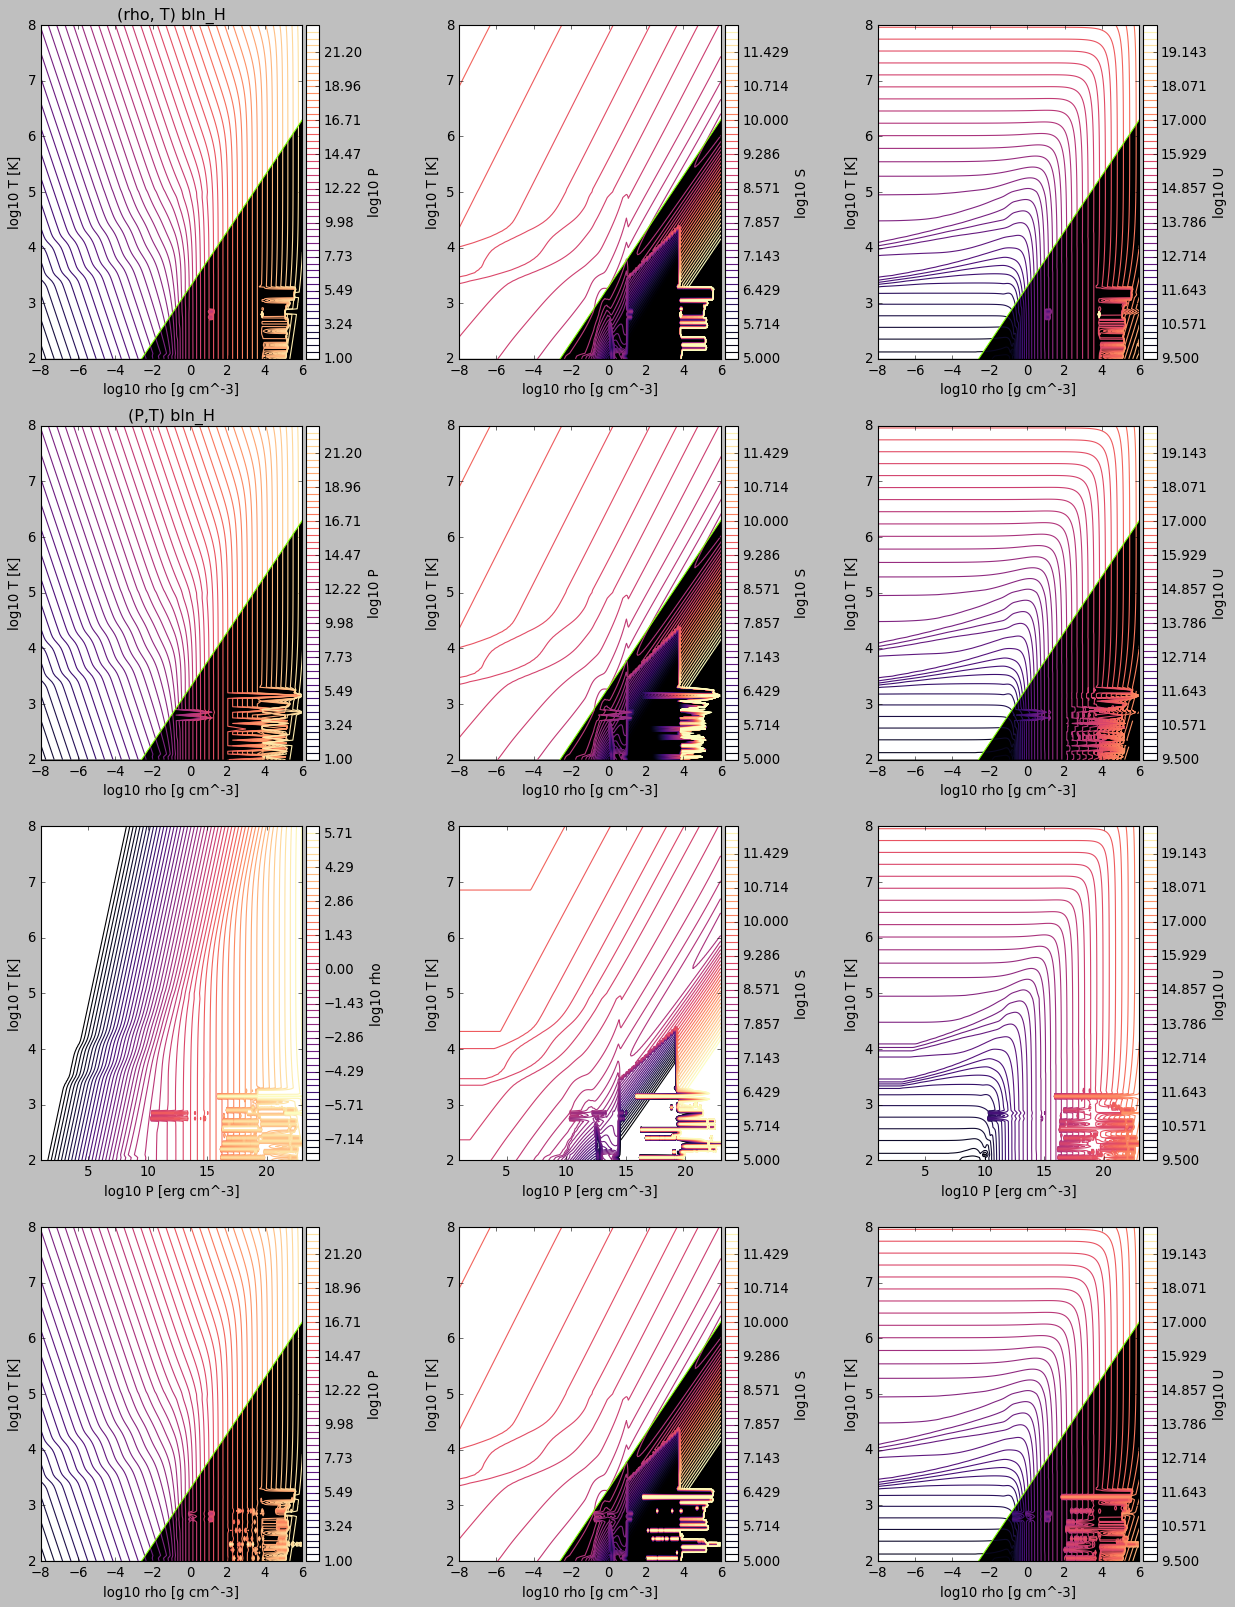

In [56]:
log10Plevels = np.linspace(1,23,50)
log10Pvmin = 0.
log10Pvmax = 24

log10Slevels = np.linspace(5,12,50)
log10Svmin = 5
log10Svmax = 12

log10Ulevels = np.linspace(9.5,20,50)
log10Uvmin = 9.5
log10Uvmax = 20

log10rholevels = np.linspace(-8,6,50)
log10rhovmin = -8.
log10rhovmax = 6


fig, axes = plt.subplots(4,3,figsize=(18,24))

# row 0: original (rho, T) version of bln_H table
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contour(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.log10Pgrid, levels=log10Plevels, cmap='magma',alpha=1,vmin=log10Pvmin, vmax=log10Pvmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='log10 P')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contour(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='log10 S')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contour(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='log10 U')

# row 1: re-based to (P,T)
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contour(bln_H_PT.log10rhogrid, bln_H_PT.log10Tgrid, bln_H_PT.log10Pgrid, levels=log10Plevels, cmap='magma',alpha=1,vmin=log10Pvmin, vmax=log10Pvmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='log10 P')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contour(bln_H_PT.log10rhogrid, bln_H_PT.log10Tgrid, bln_H_PT.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='log10 S')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
cs12 = axes[1,2].contour(bln_H_PT.log10rhogrid, bln_H_PT.log10Tgrid, bln_H_PT.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='log10 U')

# row 2: re-based to (P,T), plotted in (P,T) space
divider20 = make_axes_locatable(axes[2,0])
cax20 = divider20.append_axes('right', size='5%', pad=0.05)
cs20 = axes[2,0].contour(bln_H_PT.log10Pgrid, bln_H_PT.log10Tgrid, bln_H_PT.log10rhogrid, levels=log10rholevels, cmap='magma',alpha=1,vmin=log10rhovmin, vmax=log10rhovmax)
fig.colorbar(cs20, cax=cax20, orientation='vertical',label='log10 rho')

divider21 = make_axes_locatable(axes[2,1])
cax21 = divider21.append_axes('right', size='5%', pad=0.05)
cs21 = axes[2,1].contour(bln_H_PT.log10Pgrid, bln_H_PT.log10Tgrid, bln_H_PT.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs21, cax=cax21, orientation='vertical',label='log10 S')

divider22 = make_axes_locatable(axes[2,2])
cax22 = divider22.append_axes('right', size='5%', pad=0.05)
cs22 = axes[2,2].contour(bln_H_PT.log10Pgrid, bln_H_PT.log10Tgrid, bln_H_PT.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs22, cax=cax22, orientation='vertical',label='log10 U')


# row 3: re-based again to (rho,t)
divider30 = make_axes_locatable(axes[3,0])
cax30 = divider30.append_axes('right', size='5%', pad=0.05)
cs30 = axes[3,0].contour(bln_H_rhoT_reinterp.log10rhogrid, bln_H_rhoT_reinterp.log10Tgrid, bln_H_rhoT_reinterp.log10Pgrid, levels=log10Plevels, cmap='magma',alpha=1,vmin=log10Pvmin, vmax=log10Pvmax)
fig.colorbar(cs30, cax=cax30, orientation='vertical',label='log10 P')

divider31 = make_axes_locatable(axes[3,1])
cax31 = divider31.append_axes('right', size='5%', pad=0.05)
cs31 = axes[3,1].contour(bln_H_rhoT_reinterp.log10rhogrid, bln_H_rhoT_reinterp.log10Tgrid, bln_H_rhoT_reinterp.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs31, cax=cax31, orientation='vertical',label='log10 S')

divider32 = make_axes_locatable(axes[3,2])
cax32 = divider32.append_axes('right', size='5%', pad=0.05)
cs32 = axes[3,2].contour(bln_H_rhoT_reinterp.log10rhogrid, bln_H_rhoT_reinterp.log10Tgrid, bln_H_rhoT_reinterp.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs32, cax=cax32, orientation='vertical',label='log10 U')


for ax in np.ravel(axes[0:2]):
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')

for ax in axes[2]:
    ax.set_xlim(1.,23.)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 P [erg cm^-3]')
    ax.set_ylabel('log10 T [K]')

for ax in axes[3]:
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')
    #ax.axvline(-5.5,color='r')
    #ax.axvline(-6.5,color='r')

    
axes[0,0].set_title("(rho, T) bln_H")
axes[1,0].set_title("(P,T) bln_H")

plt.subplots_adjust(wspace=0.5)
plt.show()


# pure He

In [57]:
start = time.time()
cms_He_PT = interpolated_PTtable(cms_He)
end = time.time()
print((end-start)/60.)

5.001803867022196


In [58]:
start = time.time()
cms_He_rhoT_reinterp = reinterpolate_mixed_table_to_rhoT(cms_He_PT,reference_Pgrid=cms_He.log10Pgrid,X=0,Y=1)
end = time.time()
print((end-start)/60.)

1.9472770889600117


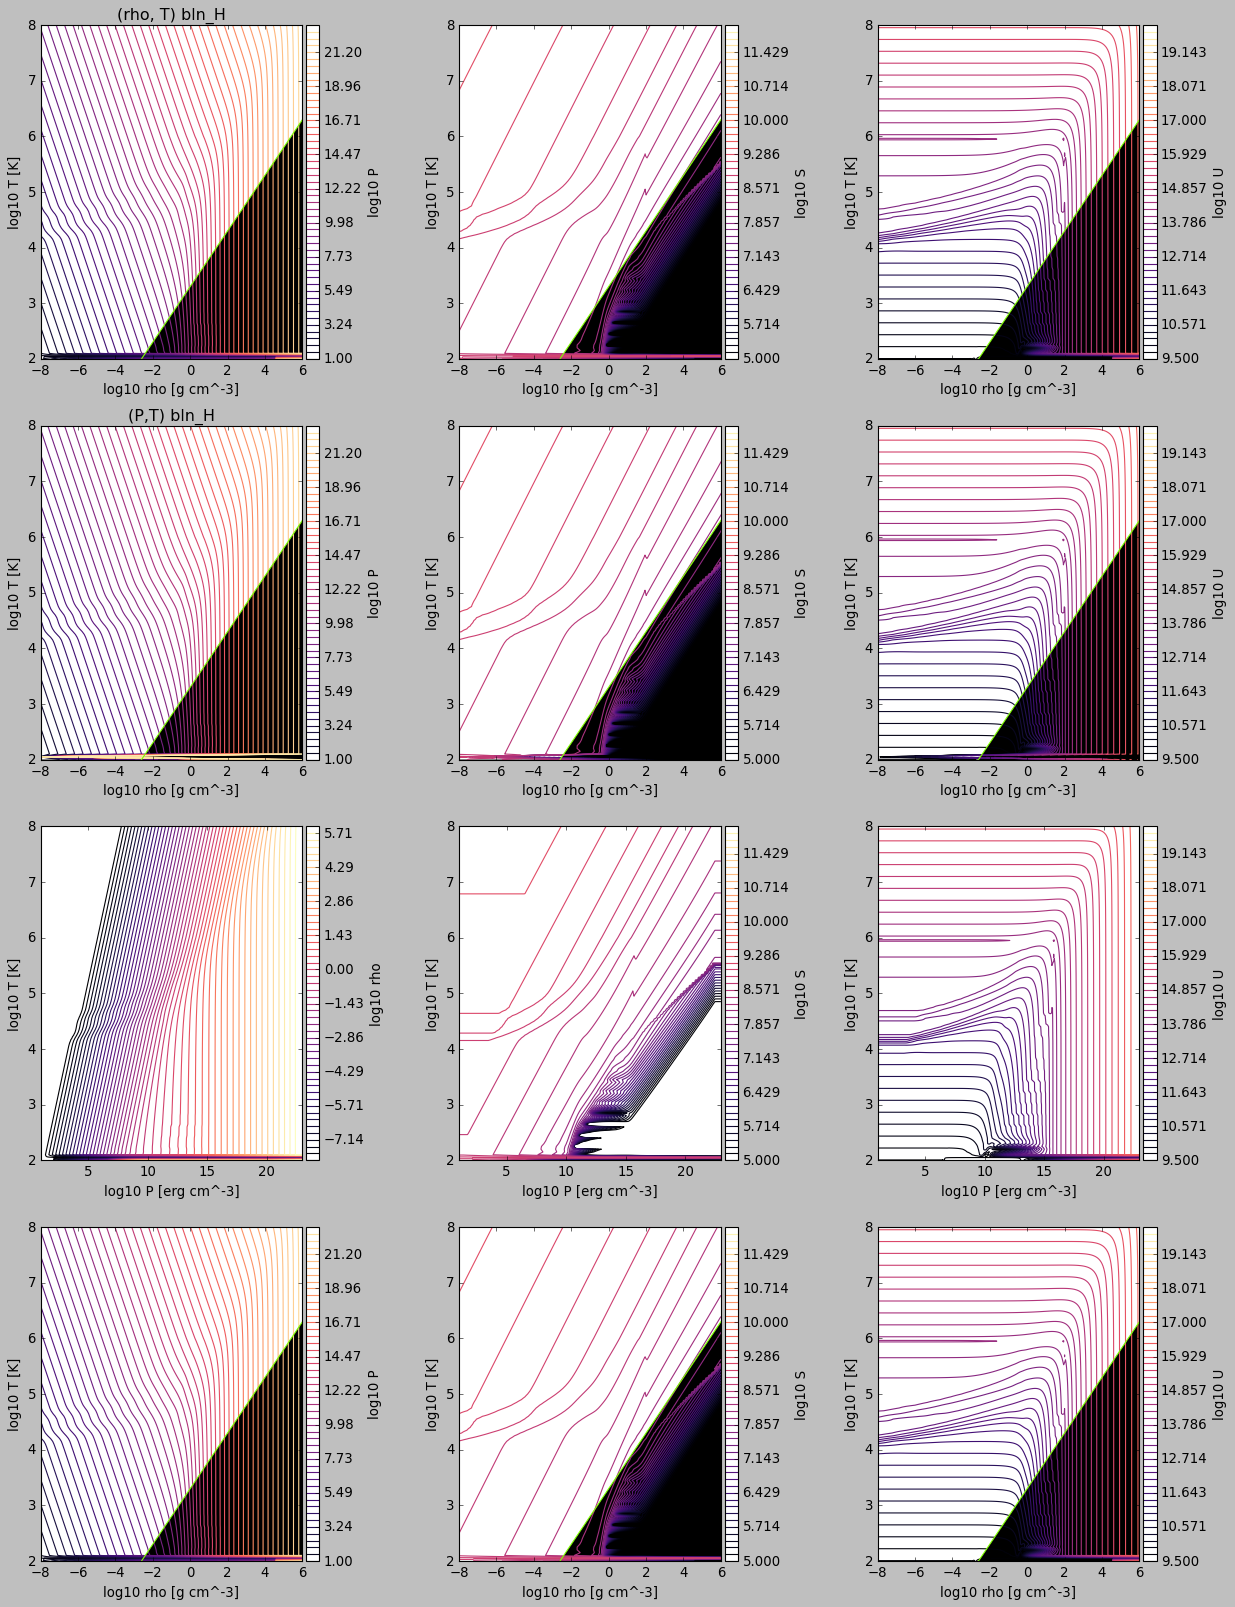

In [59]:
log10Plevels = np.linspace(1,23,50)
log10Pvmin = 0.
log10Pvmax = 24

log10Slevels = np.linspace(5,12,50)
log10Svmin = 5
log10Svmax = 12

log10Ulevels = np.linspace(9.5,20,50)
log10Uvmin = 9.5
log10Uvmax = 20

log10rholevels = np.linspace(-8,6,50)
log10rhovmin = -8.
log10rhovmax = 6


fig, axes = plt.subplots(4,3,figsize=(18,24))

# row 0: original (rho, T) version of bln_H table
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contour(cms_He.log10rhogrid, cms_He.log10Tgrid, cms_He.log10Pgrid, levels=log10Plevels, cmap='magma',alpha=1,vmin=log10Pvmin, vmax=log10Pvmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='log10 P')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contour(cms_He.log10rhogrid, cms_He.log10Tgrid, cms_He.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='log10 S')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contour(cms_He.log10rhogrid, cms_He.log10Tgrid, cms_He.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='log10 U')

# row 1: re-based to (P,T)
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contour(cms_He_PT.log10rhogrid, cms_He_PT.log10Tgrid, cms_He_PT.log10Pgrid, levels=log10Plevels, cmap='magma',alpha=1,vmin=log10Pvmin, vmax=log10Pvmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='log10 P')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contour(cms_He_PT.log10rhogrid, cms_He_PT.log10Tgrid, cms_He_PT.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='log10 S')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
cs12 = axes[1,2].contour(cms_He_PT.log10rhogrid, cms_He_PT.log10Tgrid, cms_He_PT.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='log10 U')

# row 2: re-based to (P,T), plotted in (P,T) space
divider20 = make_axes_locatable(axes[2,0])
cax20 = divider20.append_axes('right', size='5%', pad=0.05)
cs20 = axes[2,0].contour(cms_He_PT.log10Pgrid, cms_He_PT.log10Tgrid, cms_He_PT.log10rhogrid, levels=log10rholevels, cmap='magma',alpha=1,vmin=log10rhovmin, vmax=log10rhovmax)
fig.colorbar(cs20, cax=cax20, orientation='vertical',label='log10 rho')

divider21 = make_axes_locatable(axes[2,1])
cax21 = divider21.append_axes('right', size='5%', pad=0.05)
cs21 = axes[2,1].contour(cms_He_PT.log10Pgrid, cms_He_PT.log10Tgrid, cms_He_PT.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs21, cax=cax21, orientation='vertical',label='log10 S')

divider22 = make_axes_locatable(axes[2,2])
cax22 = divider22.append_axes('right', size='5%', pad=0.05)
cs22 = axes[2,2].contour(cms_He_PT.log10Pgrid, cms_He_PT.log10Tgrid, cms_He_PT.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs22, cax=cax22, orientation='vertical',label='log10 U')


# row 3: re-based again to (rho,t)
divider30 = make_axes_locatable(axes[3,0])
cax30 = divider30.append_axes('right', size='5%', pad=0.05)
cs30 = axes[3,0].contour(cms_He_rhoT_reinterp.log10rhogrid, cms_He_rhoT_reinterp.log10Tgrid, cms_He_rhoT_reinterp.log10Pgrid, levels=log10Plevels, cmap='magma',alpha=1,vmin=log10Pvmin, vmax=log10Pvmax)
fig.colorbar(cs30, cax=cax30, orientation='vertical',label='log10 P')

divider31 = make_axes_locatable(axes[3,1])
cax31 = divider31.append_axes('right', size='5%', pad=0.05)
cs31 = axes[3,1].contour(cms_He_rhoT_reinterp.log10rhogrid, cms_He_rhoT_reinterp.log10Tgrid, cms_He_rhoT_reinterp.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs31, cax=cax31, orientation='vertical',label='log10 S')

divider32 = make_axes_locatable(axes[3,2])
cax32 = divider32.append_axes('right', size='5%', pad=0.05)
cs32 = axes[3,2].contour(cms_He_rhoT_reinterp.log10rhogrid, cms_He_rhoT_reinterp.log10Tgrid, cms_He_rhoT_reinterp.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs32, cax=cax32, orientation='vertical',label='log10 U')


for ax in np.ravel(axes[0:2]):
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')

for ax in axes[2]:
    ax.set_xlim(1.,23.)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 P [erg cm^-3]')
    ax.set_ylabel('log10 T [K]')

for ax in axes[3]:
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')
    #ax.axvline(-5.5,color='r')
    #ax.axvline(-6.5,color='r')

    
axes[0,0].set_title("(rho, T) bln_H")
axes[1,0].set_title("(P,T) bln_H")

plt.subplots_adjust(wspace=0.5)
plt.show()


# mixed tables

-270.36971444541535
7.038508489967395
-10238151801.193224
77341822204727.23
-22040763200934.375
8086301753918.012


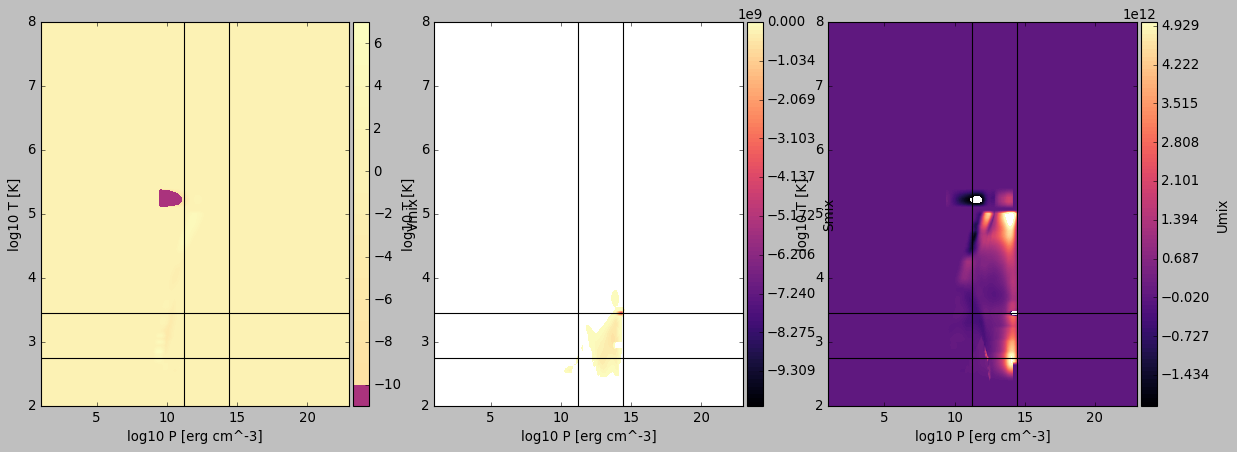

In [60]:
# plot Vmix, Smix across the P,T grid
HG23 = np.genfromtxt("/Users/emily/Documents/astro/giant_planets/MESA_EoS/HG23_Vmix_Smix_Umix.csv",delimiter=',')

Tarr = np.arange(2.,8.04,0.05)
Parr = np.arange(1.0,23.04,0.05)

HG23_log10Tgrid, HG23_log10Pgrid = np.meshgrid(Tarr, Parr)
HG23_Vmixgrid = np.zeros_like(HG23_log10Tgrid)
HG23_Smixgrid = np.zeros_like(HG23_log10Tgrid)
HG23_Umixgrid = np.zeros_like(HG23_log10Tgrid)

for j in range(441):
    HG23_Vmixgrid[j] = HG23[:,2][121*j : 121*(j+1)]
    HG23_Smixgrid[j] = HG23[:,3][121*j : 121*(j+1)]
    HG23_Umixgrid[j] = HG23[:,4][121*j : 121*(j+1)]
    
print(np.min(HG23_Vmixgrid))
print(np.max(HG23_Vmixgrid))

print(np.min(HG23_Smixgrid))
print(np.max(HG23_Smixgrid))

print(np.min(HG23_Umixgrid))
print(np.max(HG23_Umixgrid))


Vmix_vmin = -270
Vmix_vmax = 7
Vmin_levels = np.array((-270.,-10.,-9,-8,-7,-6,-5.,-4,-3,-2,-1.,0.,1,2,3,4,5.,6,7))

Smix_vmin = -1.024e10
Smix_vmax = 0#1.e10#7.74e13
Smin_levels = np.linspace(Smix_vmin, Smix_vmax, 100)

Umix_vmin = -2.e12    #-1.024e10
Umix_vmax = 5.e12 #7.74e13
Umin_levels = np.linspace(Umix_vmin, Umix_vmax, 100)

fig, axes = plt.subplots(1,3,figsize=(18,6))

# row 0: original (rho, T) version of bln_H table
divider00 = make_axes_locatable(axes[0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0].contourf(HG23_log10Pgrid, HG23_log10Tgrid, HG23_Vmixgrid, levels=Vmin_levels, cmap='magma',alpha=1,vmin=Vmix_vmin, vmax=Vmix_vmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='Vmix')

divider01 = make_axes_locatable(axes[1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[1].contourf(HG23_log10Pgrid, HG23_log10Tgrid, HG23_Smixgrid, levels=Smin_levels, cmap='magma',alpha=1,vmin=Smix_vmin, vmax=Smix_vmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='Smix')

divider02 = make_axes_locatable(axes[2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[2].contourf(HG23_log10Pgrid, HG23_log10Tgrid, HG23_Umixgrid, levels=Umin_levels, cmap='magma',alpha=1,vmin=Umix_vmin, vmax=Umix_vmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='Umix')


for ax in axes:
    ax.set_xlim(1.,23.)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 P [erg cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.axhline(2.75,color='k')
    ax.axhline(3.45,color='k')
    ax.axvline(11.25,color='k')
    ax.axvline(14.45,color='k')

plt.show()


In [61]:
mixed_H_He = add_mixing_terms(H_PTtable=bln_H_PT, He_PTtable=cms_He_PT, Z_PTtable=None, X=0.1, Y=0.9, HG23path="/Users/emily/Documents/astro/giant_planets/MESA_EoS/HG23_Vmix_Smix_Umix.csv")
mixed_H_He.log10Sgrid[~np.isfinite(mixed_H_He.log10Sgrid)] = 0.

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_73095/738257404.py:58: RuntimeWarning: invalid value encountered in log10
  mixed_log10Sgrid[i,j] = np.log10(X*S_H + Y*S_He + X*Y*this_Smix)


In [62]:
start = time.time()
mixed_H_He_rhoT = reinterpolate_mixed_table_to_rhoT(mixed_H_He,reference_Pgrid=cms_He.log10Pgrid, X=0.1, Y=0.9)
end = time.time()
print((end-start)/60.)

3.2146794478098553


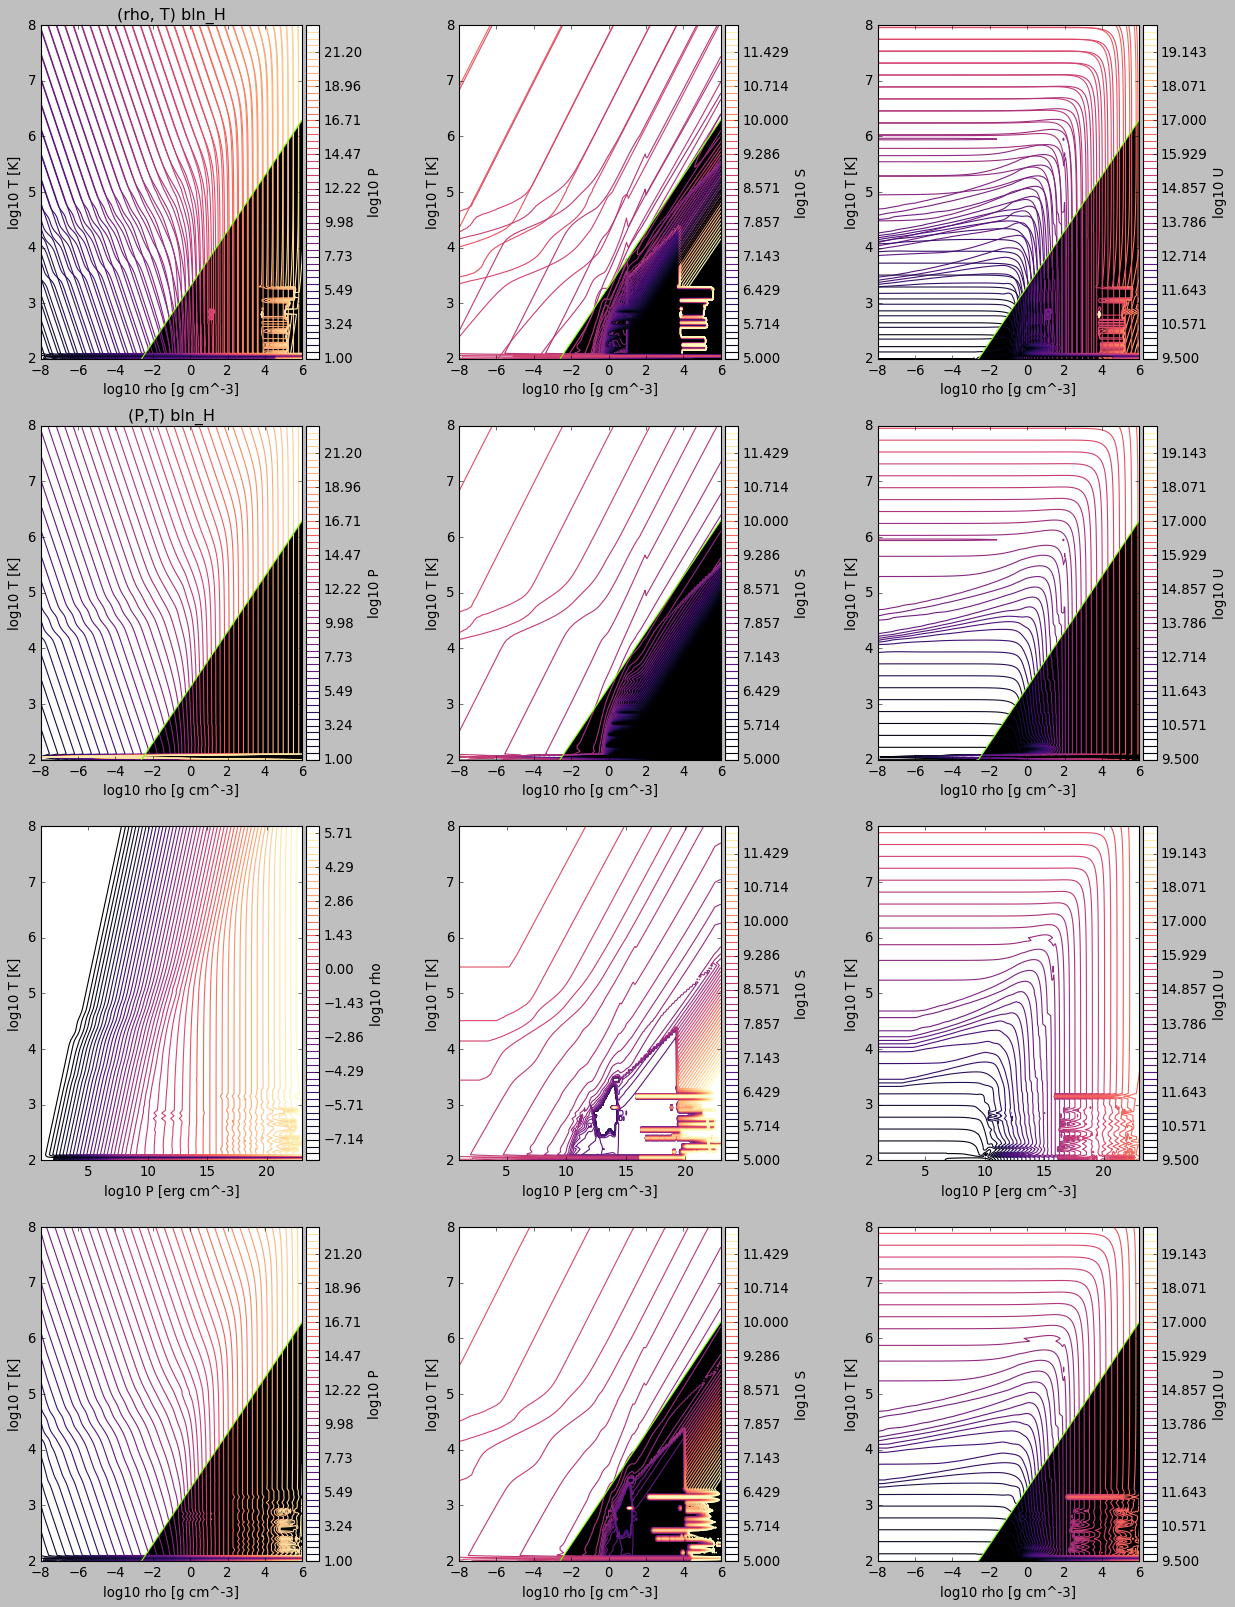

In [63]:
log10Plevels = np.linspace(1,23,50)
log10Pvmin = 0.
log10Pvmax = 24

log10Slevels = np.linspace(5,12,50)
log10Svmin = 5
log10Svmax = 12

log10Ulevels = np.linspace(9.5,20,50)
log10Uvmin = 9.5
log10Uvmax = 20

log10rholevels = np.linspace(-8,6,50)
log10rhovmin = -8.
log10rhovmax = 6


fig, axes = plt.subplots(4,3,figsize=(18,24))

# row 0: original (rho, T) version of bln_H table
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contour(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.log10Pgrid, levels=log10Plevels, cmap='magma',alpha=1,vmin=log10Pvmin, vmax=log10Pvmax)
cs00 = axes[0,0].contour(cms_He.log10rhogrid, cms_He.log10Tgrid, cms_He.log10Pgrid, levels=log10Plevels, cmap='magma',alpha=1,vmin=log10Pvmin, vmax=log10Pvmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='log10 P')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contour(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
cs01 = axes[0,1].contour(cms_He.log10rhogrid, cms_He.log10Tgrid, cms_He.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='log10 S')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contour(bln_H.log10rhogrid, bln_H.log10Tgrid, bln_H.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
cs02 = axes[0,2].contour(cms_He.log10rhogrid, cms_He.log10Tgrid, cms_He.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='log10 U')

# row 1: re-based to (P,T)
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
#cs10 = axes[1,0].contour(bln_H_PT.log10rhogrid, bln_H_PT.log10Tgrid, bln_H_PT.log10Pgrid, levels=log10Plevels, cmap='magma',alpha=1,vmin=log10Pvmin, vmax=log10Pvmax)
cs10 = axes[1,0].contour(cms_He_PT.log10rhogrid, cms_He_PT.log10Tgrid, cms_He_PT.log10Pgrid, levels=log10Plevels, cmap='magma',alpha=1,vmin=log10Pvmin, vmax=log10Pvmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='log10 P')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
#cs11 = axes[1,1].contour(bln_H_PT.log10rhogrid, bln_H_PT.log10Tgrid, bln_H_PT.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
cs11 = axes[1,1].contour(cms_He_PT.log10rhogrid, cms_He_PT.log10Tgrid, cms_He_PT.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='log10 S')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
#cs12 = axes[1,2].contour(bln_H_PT.log10rhogrid, bln_H_PT.log10Tgrid, bln_H_PT.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
cs12 = axes[1,2].contour(cms_He_PT.log10rhogrid, cms_He_PT.log10Tgrid, cms_He_PT.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='log10 U')

# row 2: re-based to (P,T), plotted in (P,T) space
divider20 = make_axes_locatable(axes[2,0])
cax20 = divider20.append_axes('right', size='5%', pad=0.05)
cs20 = axes[2,0].contour(mixed_H_He.log10Pgrid, mixed_H_He.log10Tgrid, mixed_H_He.log10rhogrid, levels=log10rholevels, cmap='magma',alpha=1,vmin=log10rhovmin, vmax=log10rhovmax)
fig.colorbar(cs20, cax=cax20, orientation='vertical',label='log10 rho')

divider21 = make_axes_locatable(axes[2,1])
cax21 = divider21.append_axes('right', size='5%', pad=0.05)
cs21 = axes[2,1].contour(mixed_H_He.log10Pgrid, mixed_H_He.log10Tgrid, mixed_H_He.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs21, cax=cax21, orientation='vertical',label='log10 S')

divider22 = make_axes_locatable(axes[2,2])
cax22 = divider22.append_axes('right', size='5%', pad=0.05)
cs22 = axes[2,2].contour(mixed_H_He.log10Pgrid, mixed_H_He.log10Tgrid, mixed_H_He.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs22, cax=cax22, orientation='vertical',label='log10 U')


# row 3: re-based again to (rho,t)
divider30 = make_axes_locatable(axes[3,0])
cax30 = divider30.append_axes('right', size='5%', pad=0.05)
cs30 = axes[3,0].contour(mixed_H_He_rhoT.log10rhogrid, mixed_H_He_rhoT.log10Tgrid, mixed_H_He_rhoT.log10Pgrid, levels=log10Plevels, cmap='magma',alpha=1,vmin=log10Pvmin, vmax=log10Pvmax)
fig.colorbar(cs30, cax=cax30, orientation='vertical',label='log10 P')

divider31 = make_axes_locatable(axes[3,1])
cax31 = divider31.append_axes('right', size='5%', pad=0.05)
cs31 = axes[3,1].contour(mixed_H_He_rhoT.log10rhogrid, mixed_H_He_rhoT.log10Tgrid, mixed_H_He_rhoT.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs31, cax=cax31, orientation='vertical',label='log10 S')

divider32 = make_axes_locatable(axes[3,2])
cax32 = divider32.append_axes('right', size='5%', pad=0.05)
cs32 = axes[3,2].contour(mixed_H_He_rhoT.log10rhogrid, mixed_H_He_rhoT.log10Tgrid, mixed_H_He_rhoT.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs32, cax=cax32, orientation='vertical',label='log10 U')


for ax in np.ravel(axes[0:2]):
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')

for ax in axes[2]:
    ax.set_xlim(1.,23.)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 P [erg cm^-3]')
    ax.set_ylabel('log10 T [K]')

for ax in axes[3]:
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')
    #ax.axvline(-5.5,color='r')
    #ax.axvline(-6.5,color='r')

    
axes[0,0].set_title("(rho, T) bln_H")
axes[1,0].set_title("(P,T) bln_H")

plt.subplots_adjust(wspace=0.5)
plt.show()


# okay, that looks good! time to make and write a range of tables covering X mass fractions between 100 and 0.

In [64]:
Xarr = np.arange(0.1,1.0,0.1)
print(Xarr)
Yarr = 1.-Xarr
print(Yarr)

for i, xi in enumerate(Xarr):
    
    mixed_H_He = add_mixing_terms(H_PTtable=bln_H_PT, He_PTtable=cms_He_PT, Z_PTtable=None, X=Xarr[i], Y=1.-Xarr[i], HG23path="/Users/emily/Documents/astro/giant_planets/MESA_EoS/HG23_Vmix_Smix_Umix.csv")
    mixed_H_He.log10Sgrid[~np.isfinite(mixed_H_He.log10Sgrid)] = 0.

    
    start = time.time()
    if xi > 0.5:
        mixed_H_He_rhoT = reinterpolate_mixed_table_to_rhoT(mixed_H_He,reference_Pgrid=bln_H.log10Pgrid, X=Xarr[i], Y=1.-Xarr[i])
    else:
        mixed_H_He_rhoT = reinterpolate_mixed_table_to_rhoT(mixed_H_He,reference_Pgrid=cms_He.log10Pgrid, X=Xarr[i], Y=1.-Xarr[i])
    end = time.time()
    print((end-start)/60.)

    mixed_H_He_rhoT.chiRho, mixed_H_He_rhoT.dlS_dlrho_T, mixed_H_He_rhoT.dlE_dlrho_T = interpolated_finite_difference_dlrho_T(mixed_H_He_rhoT)
    mixed_H_He_rhoT.chiT, mixed_H_He_rhoT.dlS_dlT_rho = interpolated_finite_difference_dlT_rho(mixed_H_He_rhoT)

    MESA_cols_6to16(mixed_H_He_rhoT, X=Xarr[i],Y=1.-Xarr[i])

    mixed_H_He_rhoT_QT = change_table_coordinates(mixed_H_He_rhoT)
    write_MESA_table_QT(mixed_H_He_rhoT_QT, './my_MESAformat_tables/mesa-planetblend_00z{0}0x.data'.format(str(np.round(xi,1))[-1]),version=1, X=xi, Z=0.0)
    

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1]


/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_73095/738257404.py:58: RuntimeWarning: invalid value encountered in log10
  mixed_log10Sgrid[i,j] = np.log10(X*S_H + Y*S_He + X*Y*this_Smix)


3.240163818995158
[-12.   -11.95 -11.9  -11.85 -11.8  -11.75 -11.7  -11.65 -11.6  -11.55
 -11.5  -11.45 -11.4  -11.35 -11.3  -11.25 -11.2  -11.15 -11.1  -11.05
 -11.   -10.95 -10.9  -10.85 -10.8  -10.75 -10.7  -10.65 -10.6  -10.55
 -10.5  -10.45 -10.4  -10.35 -10.3  -10.25 -10.2  -10.15 -10.1  -10.05
 -10.    -9.95  -9.9   -9.85  -9.8   -9.75  -9.7   -9.65  -9.6   -9.55
  -9.5   -9.45  -9.4   -9.35  -9.3   -9.25  -9.2   -9.15  -9.1   -9.05
  -9.    -8.95  -8.9   -8.85  -8.8   -8.75  -8.7   -8.65  -8.6   -8.55
  -8.5   -8.45  -8.4   -8.35  -8.3   -8.25  -8.2   -8.15  -8.1   -8.05
  -8.    -7.95  -7.9   -7.85  -7.8   -7.75  -7.7   -7.65  -7.6   -7.55
  -7.5   -7.45  -7.4   -7.35  -7.3   -7.25  -7.2   -7.15  -7.1   -7.05
  -7.    -6.95  -6.9   -6.85  -6.8   -6.75  -6.7   -6.65  -6.6   -6.55
  -6.5   -6.45  -6.4   -6.35  -6.3   -6.25  -6.2   -6.15  -6.1   -6.05
  -6.    -5.95  -5.9   -5.85  -5.8   -5.75  -5.7   -5.65  -5.6   -5.55
  -5.5   -5.45  -5.4   -5.35  -5.3   -5.25  -5.2   -5.15  -

# pure H2O table

In [65]:

infile = open('./my_Ztables/blended_h2o.pkl','rb')
h2o = pickle.load(infile)
infile.close()

h2o.chiRho, h2o.dlS_dlrho_T, h2o.dlE_dlrho_T = interpolated_finite_difference_dlrho_T(h2o)
h2o.chiT, h2o.dlS_dlT_rho = interpolated_finite_difference_dlT_rho(h2o)


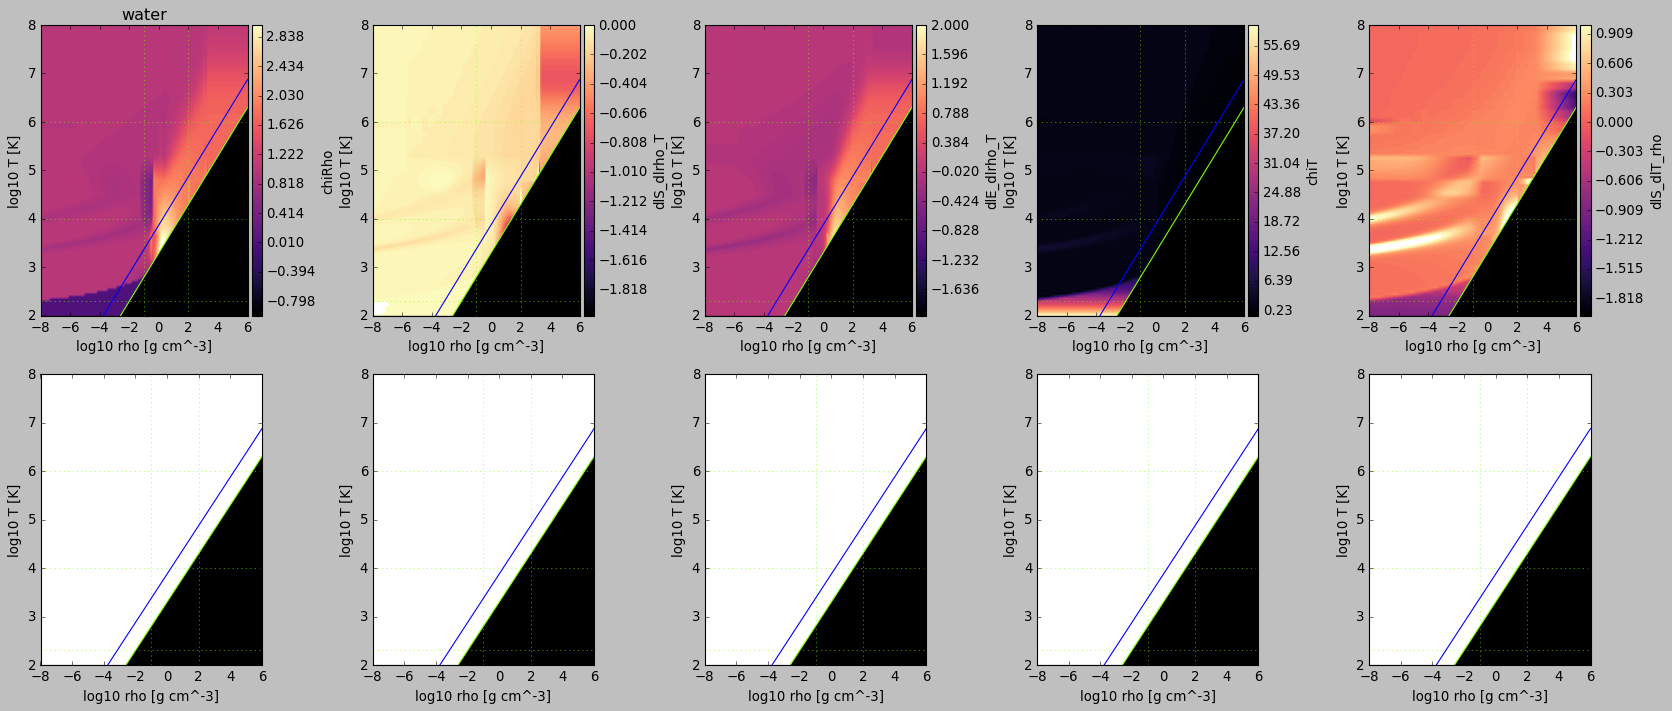

In [66]:
chiRho_vmin = -1
chiRho_vmax = 3
chiRho_levels = np.linspace(chiRho_vmin,chiRho_vmax, 100)

dlS_dlrho_T_vmin = -2
dlS_dlrho_T_vmax = 0
dlS_dlrho_T_levels = np.linspace(dlS_dlrho_T_vmin, dlS_dlrho_T_vmax, 100)

dlE_dlrho_T_vmin = -2
dlE_dlrho_T_vmax =2
dlE_dlrho_T_levels = np.linspace(dlE_dlrho_T_vmin, dlE_dlrho_T_vmax, 100)

chiT_vmin = -1
chiT_vmax = 60
chiT_levels = np.linspace(chiT_vmin,chiT_vmax, 100)

dlS_dlT_rho_vmin = -2
dlS_dlT_rho_vmax = 1
dlS_dlT_rho_levels = np.linspace(dlS_dlT_rho_vmin, dlS_dlT_rho_vmax, 100)


fig, axes = plt.subplots(2,5,figsize=(25,10))

# row 0: interpolated finite difference quantities from cms_He table
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contourf(h2o.log10rhogrid, h2o.log10Tgrid, h2o.chiRho, levels=chiRho_levels, cmap='magma',alpha=1,vmin=chiRho_vmin, vmax=chiRho_vmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='chiRho')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contourf(h2o.log10rhogrid, h2o.log10Tgrid, h2o.dlS_dlrho_T, levels=dlS_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlS_dlrho_T_vmin, vmax=dlS_dlrho_T_vmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='dlS_dlrho_T')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contourf(h2o.log10rhogrid, h2o.log10Tgrid, h2o.dlE_dlrho_T, levels=dlE_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlE_dlrho_T_vmin, vmax=dlE_dlrho_T_vmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='dlE_dlrho_T')


divider03 = make_axes_locatable(axes[0,3])
cax03 = divider03.append_axes('right', size='5%', pad=0.05)
cs03 = axes[0,3].contourf(h2o.log10rhogrid, h2o.log10Tgrid, h2o.chiT, levels=chiT_levels, cmap='magma',alpha=1,vmin=chiT_vmin, vmax=chiT_vmax)
fig.colorbar(cs03, cax=cax03, orientation='vertical',label='chiT')

divider04 = make_axes_locatable(axes[0,4])
cax04 = divider04.append_axes('right', size='5%', pad=0.05)
cs04 = axes[0,4].contourf(h2o.log10rhogrid, h2o.log10Tgrid, h2o.dlS_dlT_rho, levels=dlS_dlT_rho_levels, cmap='magma',alpha=1,vmin=dlS_dlT_rho_vmin, vmax=dlS_dlT_rho_vmax)
fig.colorbar(cs04, cax=cax04, orientation='vertical',label='dlS_dlT_rho')


'''
# row 1: interpolated finite difference quantities from cms_He table, with linearly smoothed edges of the QMD region (particularly over the horizontal line log10T = 6 and the vertical line log10rho = 2)
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, chiRho_smoothed, levels=chiRho_levels, cmap='magma',alpha=1,vmin=chiRho_vmin, vmax=chiRho_vmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='chiRho')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, dlS_dlrho_T_smoothed, levels=dlS_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlS_dlrho_T_vmin, vmax=dlS_dlrho_T_vmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='dlS_dlrho_T')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
cs12 = axes[1,2].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, dlE_dlrho_T_smoothed, levels=dlE_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlE_dlrho_T_vmin, vmax=dlE_dlrho_T_vmax)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='dlE_dlrho_T')


divider13 = make_axes_locatable(axes[1,3])
cax13 = divider13.append_axes('right', size='5%', pad=0.05)
cs13 = axes[1,3].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, chiT_smoothed, levels=chiT_levels, cmap='magma',alpha=1,vmin=chiT_vmin, vmax=chiT_vmax)
fig.colorbar(cs13, cax=cax13, orientation='vertical',label='chiT')

divider14 = make_axes_locatable(axes[1,4])
cax14 = divider14.append_axes('right', size='5%', pad=0.05)
cs14 = axes[1,4].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, dlS_dlT_rho_smoothed, levels=dlS_dlT_rho_levels, cmap='magma',alpha=1,vmin=dlS_dlT_rho_vmin, vmax=dlS_dlT_rho_vmax)
fig.colorbar(cs14, cax=cax14, orientation='vertical',label='dlS_dlT_rho')
'''
for ax in np.ravel(axes):
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')
    ax.axvline(-1,color='#7FFF00',lw=0.5,ls=':')
    ax.axvline(2,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(2.3,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(4.,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(6,color='#7FFF00',lw=0.5,ls=':')
    
    #to plot any contour log10Q = Q:
    # plot y = (x/2) + (12-Q)/2
    Qplot = 4.25
    ax.plot(np.linspace(-8,6,50), (1./2.)*np.linspace(-8,6,50) + (12-Qplot)/2, ls='-', color='b')

axes[0,0].set_title("water")
plt.subplots_adjust(wspace=0.5)
plt.show()

In [67]:
MESA_cols_6to16(h2o,X=0,Y=0)

In [68]:
h2o.log10Qgrid = h2o.log10rhogrid - 2.*h2o.log10Tgrid + 12

h2o_QT = change_table_coordinates(h2o)
write_MESA_table_QT(h2o_QT, './my_MESAformat_tables/mesa-h2o_100z00x.data',version=1, X=0.0, Z=1.0)

[-12.   -11.95 -11.9  -11.85 -11.8  -11.75 -11.7  -11.65 -11.6  -11.55
 -11.5  -11.45 -11.4  -11.35 -11.3  -11.25 -11.2  -11.15 -11.1  -11.05
 -11.   -10.95 -10.9  -10.85 -10.8  -10.75 -10.7  -10.65 -10.6  -10.55
 -10.5  -10.45 -10.4  -10.35 -10.3  -10.25 -10.2  -10.15 -10.1  -10.05
 -10.    -9.95  -9.9   -9.85  -9.8   -9.75  -9.7   -9.65  -9.6   -9.55
  -9.5   -9.45  -9.4   -9.35  -9.3   -9.25  -9.2   -9.15  -9.1   -9.05
  -9.    -8.95  -8.9   -8.85  -8.8   -8.75  -8.7   -8.65  -8.6   -8.55
  -8.5   -8.45  -8.4   -8.35  -8.3   -8.25  -8.2   -8.15  -8.1   -8.05
  -8.    -7.95  -7.9   -7.85  -7.8   -7.75  -7.7   -7.65  -7.6   -7.55
  -7.5   -7.45  -7.4   -7.35  -7.3   -7.25  -7.2   -7.15  -7.1   -7.05
  -7.    -6.95  -6.9   -6.85  -6.8   -6.75  -6.7   -6.65  -6.6   -6.55
  -6.5   -6.45  -6.4   -6.35  -6.3   -6.25  -6.2   -6.15  -6.1   -6.05
  -6.    -5.95  -5.9   -5.85  -5.8   -5.75  -5.7   -5.65  -5.6   -5.55
  -5.5   -5.45  -5.4   -5.35  -5.3   -5.25  -5.2   -5.15  -5.1   -5.05
  -5. 

# pure rock table

In [69]:
infile = open('./my_Ztables/blended_rock.pkl','rb')
rock = pickle.load(infile)
infile.close()

rock.chiRho, rock.dlS_dlrho_T, rock.dlE_dlrho_T = interpolated_finite_difference_dlrho_T(rock)
rock.chiT, rock.dlS_dlT_rho = interpolated_finite_difference_dlT_rho(rock)


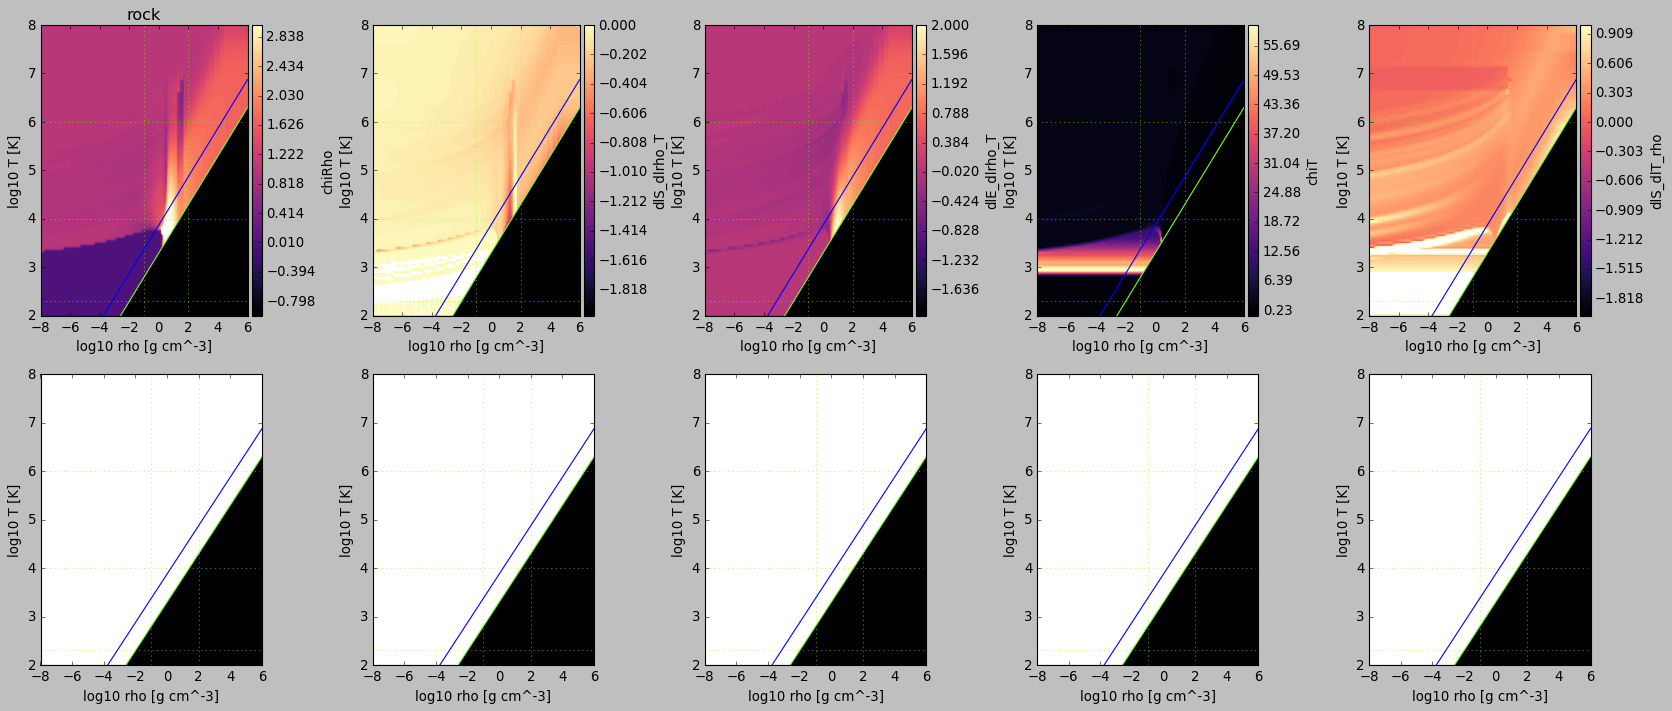

In [70]:
chiRho_vmin = -1
chiRho_vmax = 3
chiRho_levels = np.linspace(chiRho_vmin,chiRho_vmax, 100)

dlS_dlrho_T_vmin = -2
dlS_dlrho_T_vmax = 0
dlS_dlrho_T_levels = np.linspace(dlS_dlrho_T_vmin, dlS_dlrho_T_vmax, 100)

dlE_dlrho_T_vmin = -2
dlE_dlrho_T_vmax =2
dlE_dlrho_T_levels = np.linspace(dlE_dlrho_T_vmin, dlE_dlrho_T_vmax, 100)

chiT_vmin = -1
chiT_vmax = 60
chiT_levels = np.linspace(chiT_vmin,chiT_vmax, 100)

dlS_dlT_rho_vmin = -2
dlS_dlT_rho_vmax = 1
dlS_dlT_rho_levels = np.linspace(dlS_dlT_rho_vmin, dlS_dlT_rho_vmax, 100)


fig, axes = plt.subplots(2,5,figsize=(25,10))

# row 0: interpolated finite difference quantities from cms_He table
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contourf(rock.log10rhogrid, rock.log10Tgrid, rock.chiRho, levels=chiRho_levels, cmap='magma',alpha=1,vmin=chiRho_vmin, vmax=chiRho_vmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='chiRho')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contourf(rock.log10rhogrid, rock.log10Tgrid, rock.dlS_dlrho_T, levels=dlS_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlS_dlrho_T_vmin, vmax=dlS_dlrho_T_vmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='dlS_dlrho_T')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contourf(rock.log10rhogrid, rock.log10Tgrid, rock.dlE_dlrho_T, levels=dlE_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlE_dlrho_T_vmin, vmax=dlE_dlrho_T_vmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='dlE_dlrho_T')


divider03 = make_axes_locatable(axes[0,3])
cax03 = divider03.append_axes('right', size='5%', pad=0.05)
cs03 = axes[0,3].contourf(rock.log10rhogrid, rock.log10Tgrid, rock.chiT, levels=chiT_levels, cmap='magma',alpha=1,vmin=chiT_vmin, vmax=chiT_vmax)
fig.colorbar(cs03, cax=cax03, orientation='vertical',label='chiT')

divider04 = make_axes_locatable(axes[0,4])
cax04 = divider04.append_axes('right', size='5%', pad=0.05)
cs04 = axes[0,4].contourf(rock.log10rhogrid, rock.log10Tgrid, rock.dlS_dlT_rho, levels=dlS_dlT_rho_levels, cmap='magma',alpha=1,vmin=dlS_dlT_rho_vmin, vmax=dlS_dlT_rho_vmax)
fig.colorbar(cs04, cax=cax04, orientation='vertical',label='dlS_dlT_rho')


'''
# row 1: interpolated finite difference quantities from cms_He table, with linearly smoothed edges of the QMD region (particularly over the horizontal line log10T = 6 and the vertical line log10rho = 2)
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, chiRho_smoothed, levels=chiRho_levels, cmap='magma',alpha=1,vmin=chiRho_vmin, vmax=chiRho_vmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='chiRho')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, dlS_dlrho_T_smoothed, levels=dlS_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlS_dlrho_T_vmin, vmax=dlS_dlrho_T_vmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='dlS_dlrho_T')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
cs12 = axes[1,2].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, dlE_dlrho_T_smoothed, levels=dlE_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlE_dlrho_T_vmin, vmax=dlE_dlrho_T_vmax)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='dlE_dlrho_T')


divider13 = make_axes_locatable(axes[1,3])
cax13 = divider13.append_axes('right', size='5%', pad=0.05)
cs13 = axes[1,3].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, chiT_smoothed, levels=chiT_levels, cmap='magma',alpha=1,vmin=chiT_vmin, vmax=chiT_vmax)
fig.colorbar(cs13, cax=cax13, orientation='vertical',label='chiT')

divider14 = make_axes_locatable(axes[1,4])
cax14 = divider14.append_axes('right', size='5%', pad=0.05)
cs14 = axes[1,4].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, dlS_dlT_rho_smoothed, levels=dlS_dlT_rho_levels, cmap='magma',alpha=1,vmin=dlS_dlT_rho_vmin, vmax=dlS_dlT_rho_vmax)
fig.colorbar(cs14, cax=cax14, orientation='vertical',label='dlS_dlT_rho')
'''
for ax in np.ravel(axes):
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')
    ax.axvline(-1,color='#7FFF00',lw=0.5,ls=':')
    ax.axvline(2,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(2.3,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(4.,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(6,color='#7FFF00',lw=0.5,ls=':')
    
    #to plot any contour log10Q = Q:
    # plot y = (x/2) + (12-Q)/2
    Qplot = 4.25
    ax.plot(np.linspace(-8,6,50), (1./2.)*np.linspace(-8,6,50) + (12-Qplot)/2, ls='-', color='b')

axes[0,0].set_title("rock")
plt.subplots_adjust(wspace=0.5)
plt.show()

In [71]:
MESA_cols_6to16(rock,X=0,Y=0)

In [72]:
rock.log10Qgrid = rock.log10rhogrid - 2.*rock.log10Tgrid + 12

rock_QT = change_table_coordinates(rock)
write_MESA_table_QT(rock_QT, './my_MESAformat_tables/mesa-rock_100z00x.data',version=1, X=0.0, Z=1.0)

[-12.   -11.95 -11.9  -11.85 -11.8  -11.75 -11.7  -11.65 -11.6  -11.55
 -11.5  -11.45 -11.4  -11.35 -11.3  -11.25 -11.2  -11.15 -11.1  -11.05
 -11.   -10.95 -10.9  -10.85 -10.8  -10.75 -10.7  -10.65 -10.6  -10.55
 -10.5  -10.45 -10.4  -10.35 -10.3  -10.25 -10.2  -10.15 -10.1  -10.05
 -10.    -9.95  -9.9   -9.85  -9.8   -9.75  -9.7   -9.65  -9.6   -9.55
  -9.5   -9.45  -9.4   -9.35  -9.3   -9.25  -9.2   -9.15  -9.1   -9.05
  -9.    -8.95  -8.9   -8.85  -8.8   -8.75  -8.7   -8.65  -8.6   -8.55
  -8.5   -8.45  -8.4   -8.35  -8.3   -8.25  -8.2   -8.15  -8.1   -8.05
  -8.    -7.95  -7.9   -7.85  -7.8   -7.75  -7.7   -7.65  -7.6   -7.55
  -7.5   -7.45  -7.4   -7.35  -7.3   -7.25  -7.2   -7.15  -7.1   -7.05
  -7.    -6.95  -6.9   -6.85  -6.8   -6.75  -6.7   -6.65  -6.6   -6.55
  -6.5   -6.45  -6.4   -6.35  -6.3   -6.25  -6.2   -6.15  -6.1   -6.05
  -6.    -5.95  -5.9   -5.85  -5.8   -5.75  -5.7   -5.65  -5.6   -5.55
  -5.5   -5.45  -5.4   -5.35  -5.3   -5.25  -5.2   -5.15  -5.1   -5.05
  -5. 

# iron

In [73]:
infile = open('./my_Ztables/blended_iron.pkl','rb')
iron = pickle.load(infile)
infile.close()

iron.chiRho, iron.dlS_dlrho_T, iron.dlE_dlrho_T = interpolated_finite_difference_dlrho_T(iron)
iron.chiT, iron.dlS_dlT_rho = interpolated_finite_difference_dlT_rho(iron)


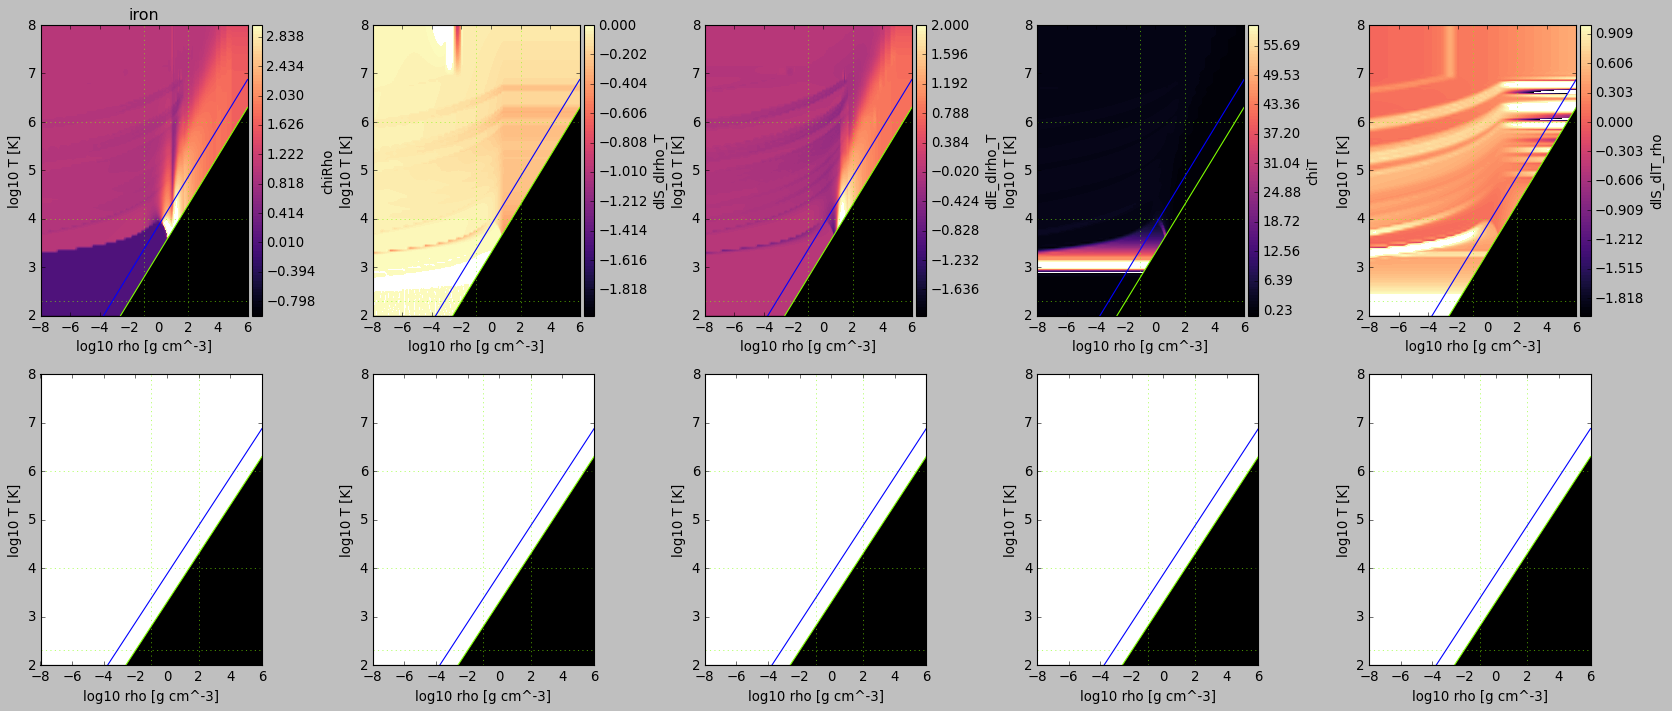

In [74]:
chiRho_vmin = -1
chiRho_vmax = 3
chiRho_levels = np.linspace(chiRho_vmin,chiRho_vmax, 100)

dlS_dlrho_T_vmin = -2
dlS_dlrho_T_vmax = 0
dlS_dlrho_T_levels = np.linspace(dlS_dlrho_T_vmin, dlS_dlrho_T_vmax, 100)

dlE_dlrho_T_vmin = -2
dlE_dlrho_T_vmax =2
dlE_dlrho_T_levels = np.linspace(dlE_dlrho_T_vmin, dlE_dlrho_T_vmax, 100)

chiT_vmin = -1
chiT_vmax = 60
chiT_levels = np.linspace(chiT_vmin,chiT_vmax, 100)

dlS_dlT_rho_vmin = -2
dlS_dlT_rho_vmax = 1
dlS_dlT_rho_levels = np.linspace(dlS_dlT_rho_vmin, dlS_dlT_rho_vmax, 100)


fig, axes = plt.subplots(2,5,figsize=(25,10))

# row 0: interpolated finite difference quantities from cms_He table
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contourf(iron.log10rhogrid, iron.log10Tgrid, iron.chiRho, levels=chiRho_levels, cmap='magma',alpha=1,vmin=chiRho_vmin, vmax=chiRho_vmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='chiRho')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contourf(iron.log10rhogrid, iron.log10Tgrid, iron.dlS_dlrho_T, levels=dlS_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlS_dlrho_T_vmin, vmax=dlS_dlrho_T_vmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='dlS_dlrho_T')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contourf(iron.log10rhogrid, iron.log10Tgrid, iron.dlE_dlrho_T, levels=dlE_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlE_dlrho_T_vmin, vmax=dlE_dlrho_T_vmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='dlE_dlrho_T')


divider03 = make_axes_locatable(axes[0,3])
cax03 = divider03.append_axes('right', size='5%', pad=0.05)
cs03 = axes[0,3].contourf(iron.log10rhogrid, iron.log10Tgrid, iron.chiT, levels=chiT_levels, cmap='magma',alpha=1,vmin=chiT_vmin, vmax=chiT_vmax)
fig.colorbar(cs03, cax=cax03, orientation='vertical',label='chiT')

divider04 = make_axes_locatable(axes[0,4])
cax04 = divider04.append_axes('right', size='5%', pad=0.05)
cs04 = axes[0,4].contourf(iron.log10rhogrid, iron.log10Tgrid, iron.dlS_dlT_rho, levels=dlS_dlT_rho_levels, cmap='magma',alpha=1,vmin=dlS_dlT_rho_vmin, vmax=dlS_dlT_rho_vmax)
fig.colorbar(cs04, cax=cax04, orientation='vertical',label='dlS_dlT_rho')


'''
# row 1: interpolated finite difference quantities from cms_He table, with linearly smoothed edges of the QMD region (particularly over the horizontal line log10T = 6 and the vertical line log10rho = 2)
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, chiRho_smoothed, levels=chiRho_levels, cmap='magma',alpha=1,vmin=chiRho_vmin, vmax=chiRho_vmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='chiRho')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, dlS_dlrho_T_smoothed, levels=dlS_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlS_dlrho_T_vmin, vmax=dlS_dlrho_T_vmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='dlS_dlrho_T')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
cs12 = axes[1,2].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, dlE_dlrho_T_smoothed, levels=dlE_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlE_dlrho_T_vmin, vmax=dlE_dlrho_T_vmax)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='dlE_dlrho_T')


divider13 = make_axes_locatable(axes[1,3])
cax13 = divider13.append_axes('right', size='5%', pad=0.05)
cs13 = axes[1,3].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, chiT_smoothed, levels=chiT_levels, cmap='magma',alpha=1,vmin=chiT_vmin, vmax=chiT_vmax)
fig.colorbar(cs13, cax=cax13, orientation='vertical',label='chiT')

divider14 = make_axes_locatable(axes[1,4])
cax14 = divider14.append_axes('right', size='5%', pad=0.05)
cs14 = axes[1,4].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, dlS_dlT_rho_smoothed, levels=dlS_dlT_rho_levels, cmap='magma',alpha=1,vmin=dlS_dlT_rho_vmin, vmax=dlS_dlT_rho_vmax)
fig.colorbar(cs14, cax=cax14, orientation='vertical',label='dlS_dlT_rho')
'''
for ax in np.ravel(axes):
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')
    ax.axvline(-1,color='#7FFF00',lw=0.5,ls=':')
    ax.axvline(2,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(2.3,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(4.,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(6,color='#7FFF00',lw=0.5,ls=':')
    
    #to plot any contour log10Q = Q:
    # plot y = (x/2) + (12-Q)/2
    Qplot = 4.25
    ax.plot(np.linspace(-8,6,50), (1./2.)*np.linspace(-8,6,50) + (12-Qplot)/2, ls='-', color='b')

axes[0,0].set_title("iron")
plt.subplots_adjust(wspace=0.5)
plt.show()

In [75]:
MESA_cols_6to16(iron,X=0,Y=0)

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_73095/3650699776.py:21: RuntimeWarning: divide by zero encountered in divide
  dlrho_dlT_P = -1. * table.chiT/table.chiRho
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_73095/3650699776.py:22: RuntimeWarning: divide by zero encountered in divide
  dlrho_dlP_T = 1./table.chiRho
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_73095/3650699776.py:24: RuntimeWarning: divide by zero encountered in divide
  dlS_dlT_P = table.dlS_dlT_rho - (table.dlS_dlrho_T * (table.chiT/table.chiRho))
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_73095/3650699776.py:25: RuntimeWarning: divide by zero encountered in divide
  dlS_dlP_T = table.dlS_dlrho_T/table.chiRho


In [76]:
iron.log10Qgrid = iron.log10rhogrid - 2.*iron.log10Tgrid + 12

iron_QT = change_table_coordinates(iron)
write_MESA_table_QT(iron_QT, './my_MESAformat_tables/mesa-iron_100z00x.data',version=1, X=0.0, Z=1.0)

[-12.   -11.95 -11.9  -11.85 -11.8  -11.75 -11.7  -11.65 -11.6  -11.55
 -11.5  -11.45 -11.4  -11.35 -11.3  -11.25 -11.2  -11.15 -11.1  -11.05
 -11.   -10.95 -10.9  -10.85 -10.8  -10.75 -10.7  -10.65 -10.6  -10.55
 -10.5  -10.45 -10.4  -10.35 -10.3  -10.25 -10.2  -10.15 -10.1  -10.05
 -10.    -9.95  -9.9   -9.85  -9.8   -9.75  -9.7   -9.65  -9.6   -9.55
  -9.5   -9.45  -9.4   -9.35  -9.3   -9.25  -9.2   -9.15  -9.1   -9.05
  -9.    -8.95  -8.9   -8.85  -8.8   -8.75  -8.7   -8.65  -8.6   -8.55
  -8.5   -8.45  -8.4   -8.35  -8.3   -8.25  -8.2   -8.15  -8.1   -8.05
  -8.    -7.95  -7.9   -7.85  -7.8   -7.75  -7.7   -7.65  -7.6   -7.55
  -7.5   -7.45  -7.4   -7.35  -7.3   -7.25  -7.2   -7.15  -7.1   -7.05
  -7.    -6.95  -6.9   -6.85  -6.8   -6.75  -6.7   -6.65  -6.6   -6.55
  -6.5   -6.45  -6.4   -6.35  -6.3   -6.25  -6.2   -6.15  -6.1   -6.05
  -6.    -5.95  -5.9   -5.85  -5.8   -5.75  -5.7   -5.65  -5.6   -5.55
  -5.5   -5.45  -5.4   -5.35  -5.3   -5.25  -5.2   -5.15  -5.1   -5.05
  -5. 

# 50-50 water/rock

In [77]:
def blend_z1_z2(z1table, z2table, z1frac = 0.5):

    Z = 1.
    z2frac = Z - z1frac

    shared_log10Tgrid = z1table.log10Tgrid
    shared_log10Pgrid = z1table.log10Pgrid

    mixed_table = simple_table()
    mixed_table.X = 0
    mixed_table.Y = 0
    mixed_table.log10Tgrid = shared_log10Tgrid
    mixed_table.log10Pgrid = shared_log10Pgrid

    mixed_log10rhogrid = np.zeros_like(shared_log10Tgrid)
    mixed_log10Sgrid = np.zeros_like(shared_log10Tgrid)
    mixed_log10Ugrid = np.zeros_like(shared_log10Tgrid)

    Tarr = np.arange(2.,8.04,0.05)
    rhoarr = np.arange(-8.,6.04,0.05)

    for i, rho in enumerate(rhoarr):
        for j, T in enumerate(Tarr):
            
            rho_z1= 10**z1table.log10rhogrid[i,j]
            rho_z2 = 10**z2table.log10rhogrid[i,j]

            S_z1 = 10**z1table.log10Sgrid[i,j]
            S_z2 = 10**z2table.log10Sgrid[i,j]

            U_z1 = 10**z1table.log10Ugrid[i,j]
            U_z2 = 10**z2table.log10Ugrid[i,j]

            mixed_log10rhogrid[i,j] = np.log10(1./((z1frac/rho_z1) + (z2frac/rho_z2)))
            mixed_log10Sgrid[i,j] = np.log10(z1frac*S_z1 + z2frac*S_z2)
            mixed_log10Ugrid[i,j] = np.log10(z1frac*U_z1 + z2frac*U_z2)
    
    
    mixed_table.log10rhogrid = mixed_log10rhogrid
    mixed_table.log10Sgrid = mixed_log10Sgrid
    mixed_table.log10Ugrid = mixed_log10Ugrid
    
    return mixed_table


In [78]:
infile = open('./my_Ztables/blended_h2o.pkl','rb')
h2o_toblend = pickle.load(infile)
infile.close()


In [79]:
infile = open('./my_Ztables/blended_rock.pkl','rb')
rock_toblend = pickle.load(infile)
infile.close()


In [80]:
rock_water = blend_z1_z2(z1table=h2o_toblend, z2table=rock_toblend, z1frac = 0.5)

In [81]:
rock_water.chiRho, rock_water.dlS_dlrho_T, rock_water.dlE_dlrho_T = interpolated_finite_difference_dlrho_T(rock_water)
rock_water.chiT, rock_water.dlS_dlT_rho = interpolated_finite_difference_dlT_rho(rock_water)


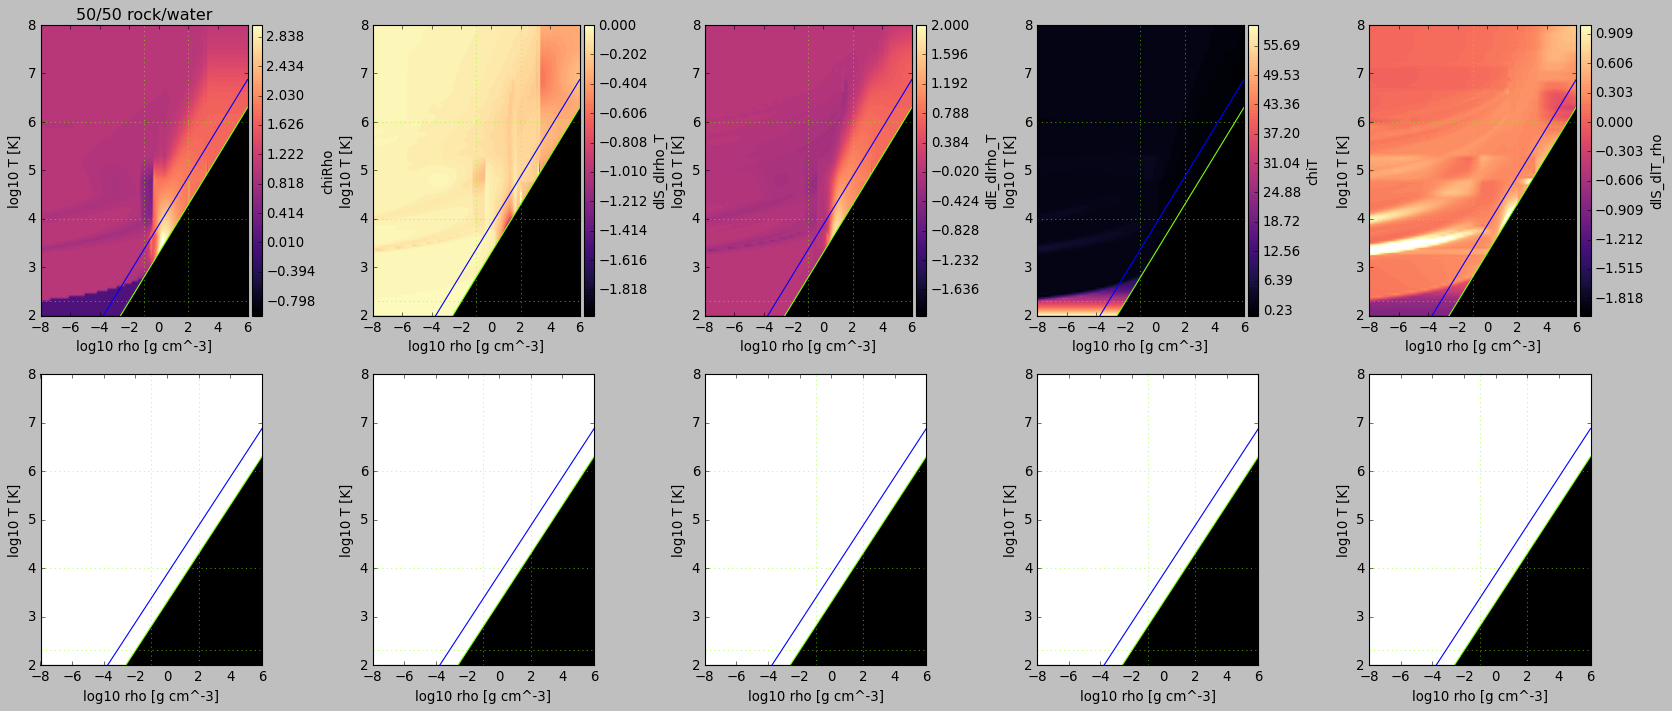

In [82]:
chiRho_vmin = -1
chiRho_vmax = 3
chiRho_levels = np.linspace(chiRho_vmin,chiRho_vmax, 100)

dlS_dlrho_T_vmin = -2
dlS_dlrho_T_vmax = 0
dlS_dlrho_T_levels = np.linspace(dlS_dlrho_T_vmin, dlS_dlrho_T_vmax, 100)

dlE_dlrho_T_vmin = -2
dlE_dlrho_T_vmax =2
dlE_dlrho_T_levels = np.linspace(dlE_dlrho_T_vmin, dlE_dlrho_T_vmax, 100)

chiT_vmin = -1
chiT_vmax = 60
chiT_levels = np.linspace(chiT_vmin,chiT_vmax, 100)

dlS_dlT_rho_vmin = -2
dlS_dlT_rho_vmax = 1
dlS_dlT_rho_levels = np.linspace(dlS_dlT_rho_vmin, dlS_dlT_rho_vmax, 100)


fig, axes = plt.subplots(2,5,figsize=(25,10))

# row 0: interpolated finite difference quantities from cms_He table
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contourf(rock_water.log10rhogrid, rock_water.log10Tgrid, rock_water.chiRho, levels=chiRho_levels, cmap='magma',alpha=1,vmin=chiRho_vmin, vmax=chiRho_vmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='chiRho')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contourf(rock_water.log10rhogrid, rock_water.log10Tgrid, rock_water.dlS_dlrho_T, levels=dlS_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlS_dlrho_T_vmin, vmax=dlS_dlrho_T_vmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='dlS_dlrho_T')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contourf(rock_water.log10rhogrid, rock_water.log10Tgrid, rock_water.dlE_dlrho_T, levels=dlE_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlE_dlrho_T_vmin, vmax=dlE_dlrho_T_vmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='dlE_dlrho_T')


divider03 = make_axes_locatable(axes[0,3])
cax03 = divider03.append_axes('right', size='5%', pad=0.05)
cs03 = axes[0,3].contourf(rock_water.log10rhogrid, rock_water.log10Tgrid, rock_water.chiT, levels=chiT_levels, cmap='magma',alpha=1,vmin=chiT_vmin, vmax=chiT_vmax)
fig.colorbar(cs03, cax=cax03, orientation='vertical',label='chiT')

divider04 = make_axes_locatable(axes[0,4])
cax04 = divider04.append_axes('right', size='5%', pad=0.05)
cs04 = axes[0,4].contourf(rock_water.log10rhogrid, rock_water.log10Tgrid, rock_water.dlS_dlT_rho, levels=dlS_dlT_rho_levels, cmap='magma',alpha=1,vmin=dlS_dlT_rho_vmin, vmax=dlS_dlT_rho_vmax)
fig.colorbar(cs04, cax=cax04, orientation='vertical',label='dlS_dlT_rho')


'''
# row 1: interpolated finite difference quantities from cms_He table, with linearly smoothed edges of the QMD region (particularly over the horizontal line log10T = 6 and the vertical line log10rho = 2)
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, chiRho_smoothed, levels=chiRho_levels, cmap='magma',alpha=1,vmin=chiRho_vmin, vmax=chiRho_vmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='chiRho')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, dlS_dlrho_T_smoothed, levels=dlS_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlS_dlrho_T_vmin, vmax=dlS_dlrho_T_vmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='dlS_dlrho_T')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
cs12 = axes[1,2].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, dlE_dlrho_T_smoothed, levels=dlE_dlrho_T_levels, cmap='magma',alpha=1,vmin=dlE_dlrho_T_vmin, vmax=dlE_dlrho_T_vmax)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='dlE_dlrho_T')


divider13 = make_axes_locatable(axes[1,3])
cax13 = divider13.append_axes('right', size='5%', pad=0.05)
cs13 = axes[1,3].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, chiT_smoothed, levels=chiT_levels, cmap='magma',alpha=1,vmin=chiT_vmin, vmax=chiT_vmax)
fig.colorbar(cs13, cax=cax13, orientation='vertical',label='chiT')

divider14 = make_axes_locatable(axes[1,4])
cax14 = divider14.append_axes('right', size='5%', pad=0.05)
cs14 = axes[1,4].contourf(cms_He.log10rhogrid, cms_He.log10Tgrid, dlS_dlT_rho_smoothed, levels=dlS_dlT_rho_levels, cmap='magma',alpha=1,vmin=dlS_dlT_rho_vmin, vmax=dlS_dlT_rho_vmax)
fig.colorbar(cs14, cax=cax14, orientation='vertical',label='dlS_dlT_rho')
'''
for ax in np.ravel(axes):
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')
    ax.axvline(-1,color='#7FFF00',lw=0.5,ls=':')
    ax.axvline(2,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(2.3,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(4.,color='#7FFF00',lw=0.5,ls=':')
    ax.axhline(6,color='#7FFF00',lw=0.5,ls=':')
    
    #to plot any contour log10Q = Q:
    # plot y = (x/2) + (12-Q)/2
    Qplot = 4.25
    ax.plot(np.linspace(-8,6,50), (1./2.)*np.linspace(-8,6,50) + (12-Qplot)/2, ls='-', color='b')

axes[0,0].set_title("50/50 rock/water")
plt.subplots_adjust(wspace=0.5)
plt.show()

In [83]:
MESA_cols_6to16(rock_water,X=0,Y=0)

In [84]:
rock_water.log10Qgrid = rock_water.log10rhogrid - 2.*rock_water.log10Tgrid + 12

rock_water_QT = change_table_coordinates(rock_water)
write_MESA_table_QT(rock_water_QT, './my_MESAformat_tables/mesa-planetblend_100z00x.data',version=1, X=0.0, Z=1.0)

[-12.   -11.95 -11.9  -11.85 -11.8  -11.75 -11.7  -11.65 -11.6  -11.55
 -11.5  -11.45 -11.4  -11.35 -11.3  -11.25 -11.2  -11.15 -11.1  -11.05
 -11.   -10.95 -10.9  -10.85 -10.8  -10.75 -10.7  -10.65 -10.6  -10.55
 -10.5  -10.45 -10.4  -10.35 -10.3  -10.25 -10.2  -10.15 -10.1  -10.05
 -10.    -9.95  -9.9   -9.85  -9.8   -9.75  -9.7   -9.65  -9.6   -9.55
  -9.5   -9.45  -9.4   -9.35  -9.3   -9.25  -9.2   -9.15  -9.1   -9.05
  -9.    -8.95  -8.9   -8.85  -8.8   -8.75  -8.7   -8.65  -8.6   -8.55
  -8.5   -8.45  -8.4   -8.35  -8.3   -8.25  -8.2   -8.15  -8.1   -8.05
  -8.    -7.95  -7.9   -7.85  -7.8   -7.75  -7.7   -7.65  -7.6   -7.55
  -7.5   -7.45  -7.4   -7.35  -7.3   -7.25  -7.2   -7.15  -7.1   -7.05
  -7.    -6.95  -6.9   -6.85  -6.8   -6.75  -6.7   -6.65  -6.6   -6.55
  -6.5   -6.45  -6.4   -6.35  -6.3   -6.25  -6.2   -6.15  -6.1   -6.05
  -6.    -5.95  -5.9   -5.85  -5.8   -5.75  -5.7   -5.65  -5.6   -5.55
  -5.5   -5.45  -5.4   -5.35  -5.3   -5.25  -5.2   -5.15  -5.1   -5.05
  -5. 

# XYZ mixture tables, 50/50 rock-water

In [85]:
print(type(rock_water))
rock_water.atomic_number = 1
rock_water.mass_number= 1

<class '__main__.simple_table'>


In [86]:
rock_water_PT = interpolated_PTtable(rock_water)

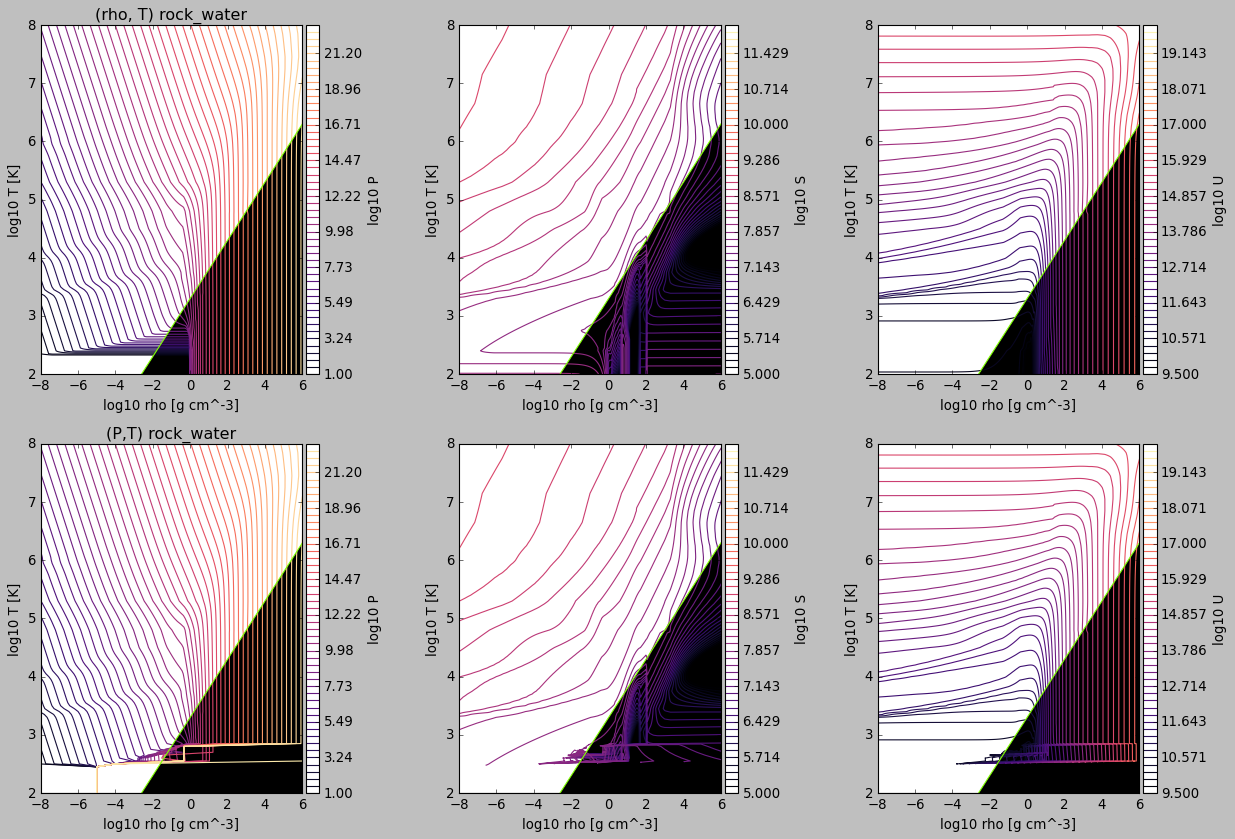

In [87]:
log10Plevels = np.linspace(1,23,50)
log10Pvmin = 0.
log10Pvmax = 24

log10Slevels = np.linspace(5,12,50)
log10Svmin = 5
log10Svmax = 12

log10Ulevels = np.linspace(9.5,20,50)
log10Uvmin = 9.5
log10Uvmax = 20

log10rholevels = np.linspace(-8,6,50)
log10rhovmin = -8.
log10rhovmax = 6


fig, axes = plt.subplots(2,3,figsize=(18,12))

# row 0: original (rho, T) version of bln_H table
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contour(rock_water.log10rhogrid, rock_water.log10Tgrid, rock_water.log10Pgrid, levels=log10Plevels, cmap='magma',alpha=1,vmin=log10Pvmin, vmax=log10Pvmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='log10 P')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contour(rock_water.log10rhogrid, rock_water.log10Tgrid, rock_water.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='log10 S')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contour(rock_water.log10rhogrid, rock_water.log10Tgrid, rock_water.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='log10 U')

# row 1: re-based to (P,T)
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contour(rock_water_PT.log10rhogrid, rock_water_PT.log10Tgrid, rock_water_PT.log10Pgrid, levels=log10Plevels, cmap='magma',alpha=1,vmin=log10Pvmin, vmax=log10Pvmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='log10 P')

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contour(rock_water_PT.log10rhogrid, rock_water_PT.log10Tgrid, rock_water_PT.log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='log10 S')

divider12 = make_axes_locatable(axes[1,2])
cax12 = divider12.append_axes('right', size='5%', pad=0.05)
cs12 = axes[1,2].contour(rock_water_PT.log10rhogrid, rock_water_PT.log10Tgrid, rock_water_PT.log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs12, cax=cax12, orientation='vertical',label='log10 U')


for ax in np.ravel(axes):
    ax.set_xlim(-8.,6)
    ax.set_ylim(2.,8)
    ax.set_xlabel('log10 rho [g cm^-3]')
    ax.set_ylabel('log10 T [K]')
    ax.plot(np.linspace(-8,6,50), 3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number), ls='-', color='#7FFF00')
    ax.fill_between(x=np.linspace(-8,6,50), y1=2,y2=3.3 + (1./2.)*np.linspace(-8,6,50) + np.log10(cms_H.atomic_number) - (5./3)*np.log10(cms_H.mass_number),color='k')

  
axes[0,0].set_title("(rho, T) rock_water")
axes[1,0].set_title("(P,T) rock_water")

plt.subplots_adjust(wspace=0.5)
plt.show()

In [88]:
Xarr = np.arange(0.0,1.0,0.1)
Zarr = np.arange(0.1,1.0,0.1)

for i, xi in enumerate(Xarr):
    for k, zi in enumerate(Zarr):

        if (xi + zi) > 1.0:
            continue
        else:

            yi = 1. - (xi + zi)
    
            print(xi, yi, zi)
            
            mixed_XYZ = add_mixing_terms(H_PTtable=bln_H_PT, He_PTtable=cms_He_PT, Z_PTtable=rock_water_PT, X=xi, Y=yi, HG23path="/Users/emily/Documents/astro/giant_planets/MESA_EoS/HG23_Vmix_Smix_Umix.csv")
            mixed_XYZ.log10Sgrid[~np.isfinite(mixed_XYZ.log10Sgrid)] = 0.
    
        
            start = time.time()
            if (xi >= yi) & (xi >= zi):
                mixed_XYZ_rhoT = reinterpolate_mixed_table_to_rhoT(mixed_H_He,reference_Pgrid=bln_H.log10Pgrid, X=xi, Y=yi)
            elif (yi > xi) & (yi >= zi):
                mixed_XYZ_rhoT = reinterpolate_mixed_table_to_rhoT(mixed_H_He,reference_Pgrid=cms_He.log10Pgrid, X=xi, Y=yi)
            else:
                mixed_XYZ_rhoT = reinterpolate_mixed_table_to_rhoT(mixed_H_He,reference_Pgrid=rock_water.log10Pgrid, X=xi, Y=yi)
            end = time.time()
            print((end-start)/60.)
    
            mixed_XYZ_rhoT.chiRho, mixed_XYZ_rhoT.dlS_dlrho_T, mixed_XYZ_rhoT.dlE_dlrho_T = interpolated_finite_difference_dlrho_T(mixed_XYZ_rhoT)
            mixed_XYZ_rhoT.chiT, mixed_XYZ_rhoT.dlS_dlT_rho = interpolated_finite_difference_dlT_rho(mixed_XYZ_rhoT)
    
            MESA_cols_6to16(mixed_XYZ_rhoT, X=Xarr[i],Y=1.-(Xarr[i]+Zarr[k]))
            mixed_XYZ_rhoT_QT = change_table_coordinates(mixed_XYZ_rhoT)
            
            savefilename = './my_MESAformat_tables/mesa-planetblend_{0}0z{1}0x.data'.format(str(np.round(zi,1))[-1], str(np.round(xi,1))[-1])
            print(savefilename)
            write_MESA_table_QT(mixed_XYZ_rhoT_QT, savefilename,version=1, X=xi, Z=zi)
        

0.0 0.9 0.1
4.196336980660757
./my_MESAformat_tables/mesa-planetblend_10z00x.data
[-12.   -11.95 -11.9  -11.85 -11.8  -11.75 -11.7  -11.65 -11.6  -11.55
 -11.5  -11.45 -11.4  -11.35 -11.3  -11.25 -11.2  -11.15 -11.1  -11.05
 -11.   -10.95 -10.9  -10.85 -10.8  -10.75 -10.7  -10.65 -10.6  -10.55
 -10.5  -10.45 -10.4  -10.35 -10.3  -10.25 -10.2  -10.15 -10.1  -10.05
 -10.    -9.95  -9.9   -9.85  -9.8   -9.75  -9.7   -9.65  -9.6   -9.55
  -9.5   -9.45  -9.4   -9.35  -9.3   -9.25  -9.2   -9.15  -9.1   -9.05
  -9.    -8.95  -8.9   -8.85  -8.8   -8.75  -8.7   -8.65  -8.6   -8.55
  -8.5   -8.45  -8.4   -8.35  -8.3   -8.25  -8.2   -8.15  -8.1   -8.05
  -8.    -7.95  -7.9   -7.85  -7.8   -7.75  -7.7   -7.65  -7.6   -7.55
  -7.5   -7.45  -7.4   -7.35  -7.3   -7.25  -7.2   -7.15  -7.1   -7.05
  -7.    -6.95  -6.9   -6.85  -6.8   -6.75  -6.7   -6.65  -6.6   -6.55
  -6.5   -6.45  -6.4   -6.35  -6.3   -6.25  -6.2   -6.15  -6.1   -6.05
  -6.    -5.95  -5.9   -5.85  -5.8   -5.75  -5.7   -5.65  -5.6   -

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_73095/3650699776.py:21: RuntimeWarning: divide by zero encountered in divide
  dlrho_dlT_P = -1. * table.chiT/table.chiRho
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_73095/3650699776.py:22: RuntimeWarning: divide by zero encountered in divide
  dlrho_dlP_T = 1./table.chiRho
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_73095/3650699776.py:24: RuntimeWarning: divide by zero encountered in divide
  dlS_dlT_P = table.dlS_dlT_rho - (table.dlS_dlrho_T * (table.chiT/table.chiRho))
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_73095/3650699776.py:24: RuntimeWarning: invalid value encountered in multiply
  dlS_dlT_P = table.dlS_dlT_rho - (table.dlS_dlrho_T * (table.chiT/table.chiRho))
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_73095/3650699776.py:25: RuntimeWarning: divide by zero encountered in divide
  dlS_dlP_T = table.dlS_dlrho_T/table.chiRho
/var/folders/vr/5jyx18rn3vb6ccm0

./my_MESAformat_tables/mesa-planetblend_60z00x.data
[-12.   -11.95 -11.9  -11.85 -11.8  -11.75 -11.7  -11.65 -11.6  -11.55
 -11.5  -11.45 -11.4  -11.35 -11.3  -11.25 -11.2  -11.15 -11.1  -11.05
 -11.   -10.95 -10.9  -10.85 -10.8  -10.75 -10.7  -10.65 -10.6  -10.55
 -10.5  -10.45 -10.4  -10.35 -10.3  -10.25 -10.2  -10.15 -10.1  -10.05
 -10.    -9.95  -9.9   -9.85  -9.8   -9.75  -9.7   -9.65  -9.6   -9.55
  -9.5   -9.45  -9.4   -9.35  -9.3   -9.25  -9.2   -9.15  -9.1   -9.05
  -9.    -8.95  -8.9   -8.85  -8.8   -8.75  -8.7   -8.65  -8.6   -8.55
  -8.5   -8.45  -8.4   -8.35  -8.3   -8.25  -8.2   -8.15  -8.1   -8.05
  -8.    -7.95  -7.9   -7.85  -7.8   -7.75  -7.7   -7.65  -7.6   -7.55
  -7.5   -7.45  -7.4   -7.35  -7.3   -7.25  -7.2   -7.15  -7.1   -7.05
  -7.    -6.95  -6.9   -6.85  -6.8   -6.75  -6.7   -6.65  -6.6   -6.55
  -6.5   -6.45  -6.4   -6.35  -6.3   -6.25  -6.2   -6.15  -6.1   -6.05
  -6.    -5.95  -5.9   -5.85  -5.8   -5.75  -5.7   -5.65  -5.6   -5.55
  -5.5   -5.45  -5.4   -5

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_73095/738257404.py:82: RuntimeWarning: invalid value encountered in log10
  mixed_log10Sgrid[i,j] = np.log10(X*S_H + Y*S_He + X*Y*this_Smix + Z*S_Z)


3.977703269322713
./my_MESAformat_tables/mesa-planetblend_10z10x.data
[-12.   -11.95 -11.9  -11.85 -11.8  -11.75 -11.7  -11.65 -11.6  -11.55
 -11.5  -11.45 -11.4  -11.35 -11.3  -11.25 -11.2  -11.15 -11.1  -11.05
 -11.   -10.95 -10.9  -10.85 -10.8  -10.75 -10.7  -10.65 -10.6  -10.55
 -10.5  -10.45 -10.4  -10.35 -10.3  -10.25 -10.2  -10.15 -10.1  -10.05
 -10.    -9.95  -9.9   -9.85  -9.8   -9.75  -9.7   -9.65  -9.6   -9.55
  -9.5   -9.45  -9.4   -9.35  -9.3   -9.25  -9.2   -9.15  -9.1   -9.05
  -9.    -8.95  -8.9   -8.85  -8.8   -8.75  -8.7   -8.65  -8.6   -8.55
  -8.5   -8.45  -8.4   -8.35  -8.3   -8.25  -8.2   -8.15  -8.1   -8.05
  -8.    -7.95  -7.9   -7.85  -7.8   -7.75  -7.7   -7.65  -7.6   -7.55
  -7.5   -7.45  -7.4   -7.35  -7.3   -7.25  -7.2   -7.15  -7.1   -7.05
  -7.    -6.95  -6.9   -6.85  -6.8   -6.75  -6.7   -6.65  -6.6   -6.55
  -6.5   -6.45  -6.4   -6.35  -6.3   -6.25  -6.2   -6.15  -6.1   -6.05
  -6.    -5.95  -5.9   -5.85  -5.8   -5.75  -5.7   -5.65  -5.6   -5.55
  -5.5 

In [89]:
print(dir(bln_H))

['Cp', 'Cv', 'X', 'Y', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'atomic_number', 'chiRho', 'chiT', 'dE_drho_T', 'dE_drho_T_direct', 'dS_dT_rho', 'dS_dT_rho_direct', 'dS_drho_T', 'dS_drho_T_direct', 'dlE_dlrho_T', 'dlS_dlT_rho', 'dlS_dlrho_T', 'eta', 'gamma1', 'gamma3', 'grad_ad', 'log10Pgrid', 'log10Qgrid', 'log10Sgrid', 'log10Tgrid', 'log10Ugrid', 'log10rhogrid', 'log_free_e', 'mass_number', 'mu', 'units']


In [90]:
def plot_finite_differences_for_negative_val_investigation(table,savefilename=None):
    """
    plot the following quantities
    should be positive: dlnp_dlnrho_T, dlnp_dlnT_rho, dlnS_dlnT_P, dlnS_dlnT_rho
    should be negative: dlnS_dlnP_T, dlnS_dlnrho_T
    """
    
    physicalMask = (table.log10rhogrid >= -8) & (table.log10rhogrid <= 6) & (table.log10Tgrid >= 2) & (table.log10Tgrid <= 8) & (table.log10Qgrid <= 5.4)
    
    fig, axes = plt.subplots(3,2,figsize=(16,24))

    divider00 = make_axes_locatable(axes[0,0])
    cax00 = divider00.append_axes('right', size='5%', pad=0.05)
    cs00 = axes[0,0].contourf(table.log10rhogrid, table.log10Tgrid, np.log10(table.chiRho), cmap='magma',alpha=1)
    fig.colorbar(cs00, cax=cax00, orientation='vertical',label='dlnP_dlnrho_T')

    divider01 = make_axes_locatable(axes[0,1])
    cax01 = divider01.append_axes('right', size='5%', pad=0.05)
    cs01 = axes[0,1].contourf(table.log10rhogrid, table.log10Tgrid, np.log10(table.chiT), cmap='magma',alpha=1)
    fig.colorbar(cs01, cax=cax01, orientation='vertical',label='dlnP_dlnT_rho')


    dlS_dlT_P = table.dlS_dlT_rho - (table.chiT/table.chiRho)*table.dlS_dlrho_T
    divider10 = make_axes_locatable(axes[1,0])
    cax10 = divider10.append_axes('right', size='5%', pad=0.05)
    cs10 = axes[1,0].contourf(table.log10rhogrid, table.log10Tgrid, np.log10(dlS_dlT_P), cmap='magma',alpha=1)
    fig.colorbar(cs10, cax=cax10, orientation='vertical',label='dlnS_dlnT_P')

    divider11 = make_axes_locatable(axes[1,1])
    cax11 = divider11.append_axes('right', size='5%', pad=0.05)
    cs11 = axes[1,1].contourf(table.log10rhogrid, table.log10Tgrid, np.log10(table.dlS_dlT_rho), cmap='magma',alpha=1)
    fig.colorbar(cs11, cax=cax11, orientation='vertical',label='dlS_dlT_rho')

    dlS_dlP_T = table.dlS_dlrho_T/table.chiRho
    divider20 = make_axes_locatable(axes[2,0])
    cax20 = divider20.append_axes('right', size='5%', pad=0.05)
    cs20 = axes[2,0].contourf(table.log10rhogrid, table.log10Tgrid, np.log10(-1*dlS_dlP_T), cmap='magma',alpha=1)
    fig.colorbar(cs20, cax=cax20, orientation='vertical',label='dlnS_dlnP_T')

    divider21 = make_axes_locatable(axes[2,1])
    cax21 = divider21.append_axes('right', size='5%', pad=0.05)
    cs21 = axes[2,1].contourf(table.log10rhogrid, table.log10Tgrid, np.log10(-1*table.dlS_dlrho_T), cmap='magma',alpha=1)
    fig.colorbar(cs21, cax=cax21, orientation='vertical',label='dlnS_dlnrho_T')

    for ax in np.ravel(axes):
        ax.set_xlim(-8.,6)
        ax.set_ylim(2.,8.)
        ax.set_ylabel('log10 T [K]')
        ax.set_xlabel('log10 rho [g/cc]')
        
        ax.plot(np.linspace(-8,6,20), 3.3 + (1./2.)*np.linspace(-8,6,20) + np.log10(table.atomic_number) - (5./3)*np.log10(table.mass_number), ls='-', color='#7FFF00')
        

    if savefilename is None:
        plt.show()
    else:
        plt.savefig(savefilename,bbox_inches='tight')
        
    return

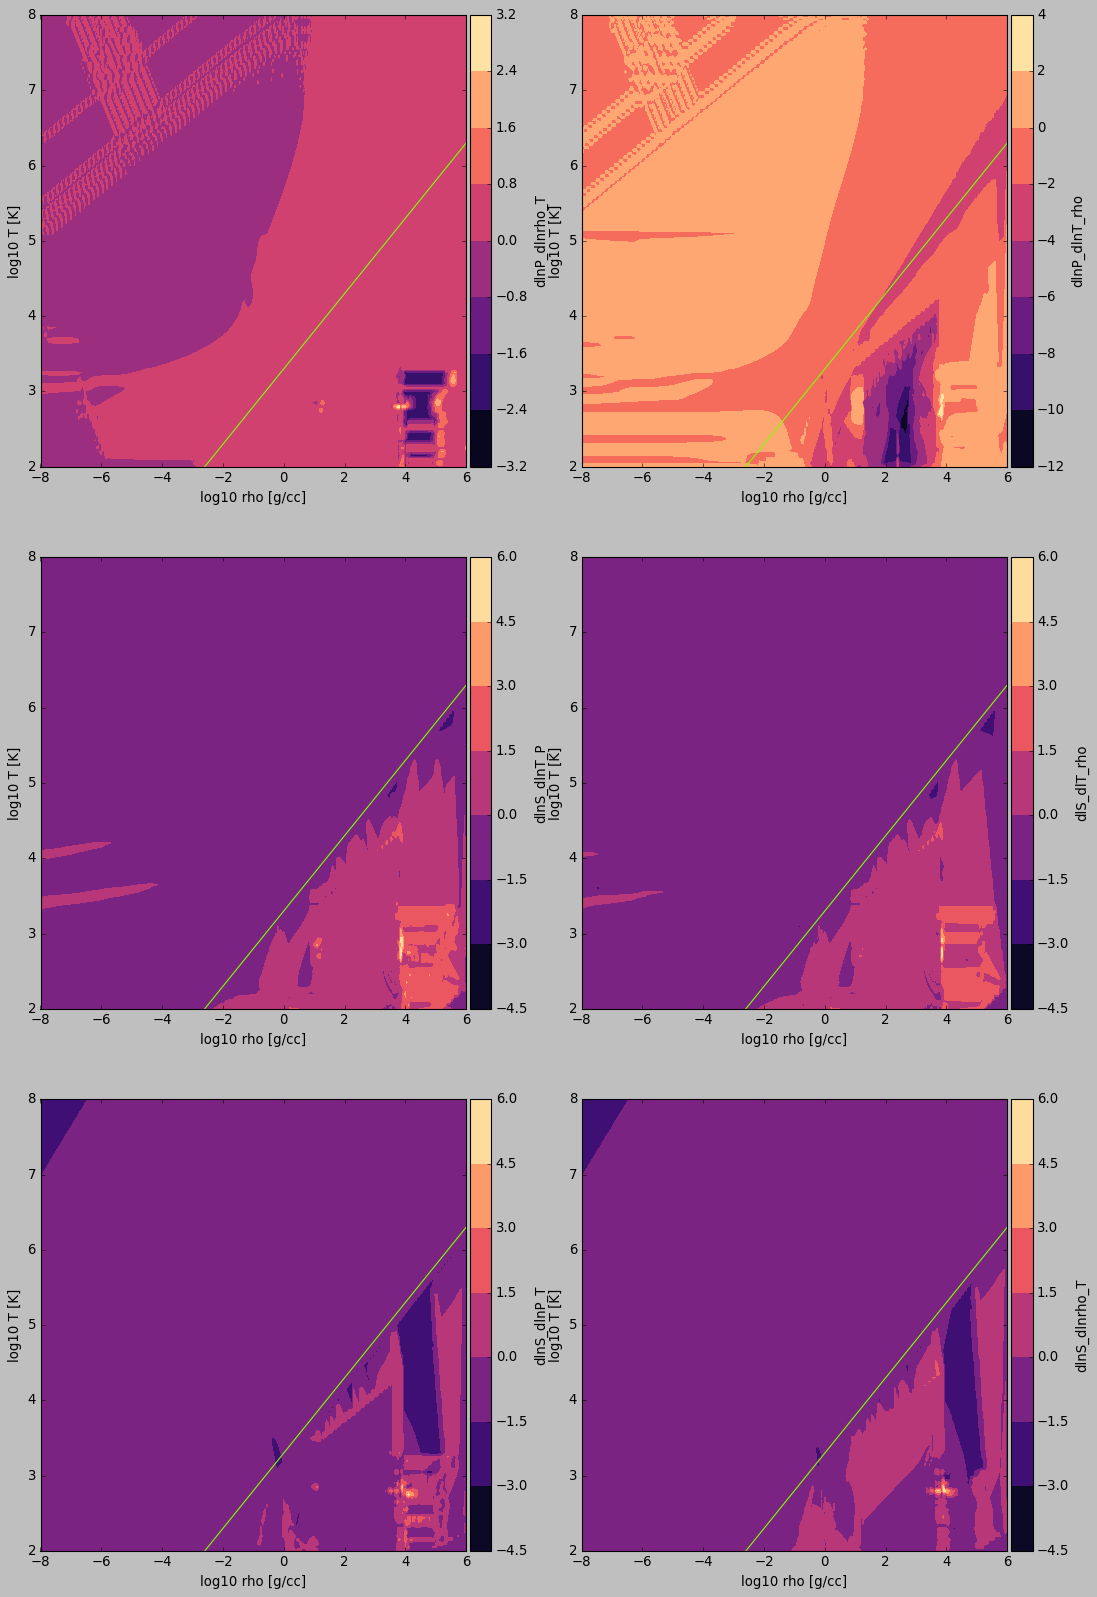

In [91]:
plot_finite_differences_for_negative_val_investigation(bln_H)

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_73095/2261567313.py:19: RuntimeWarning: invalid value encountered in log10
  cs01 = axes[0,1].contourf(table.log10rhogrid, table.log10Tgrid, np.log10(table.chiT), cmap='magma',alpha=1)


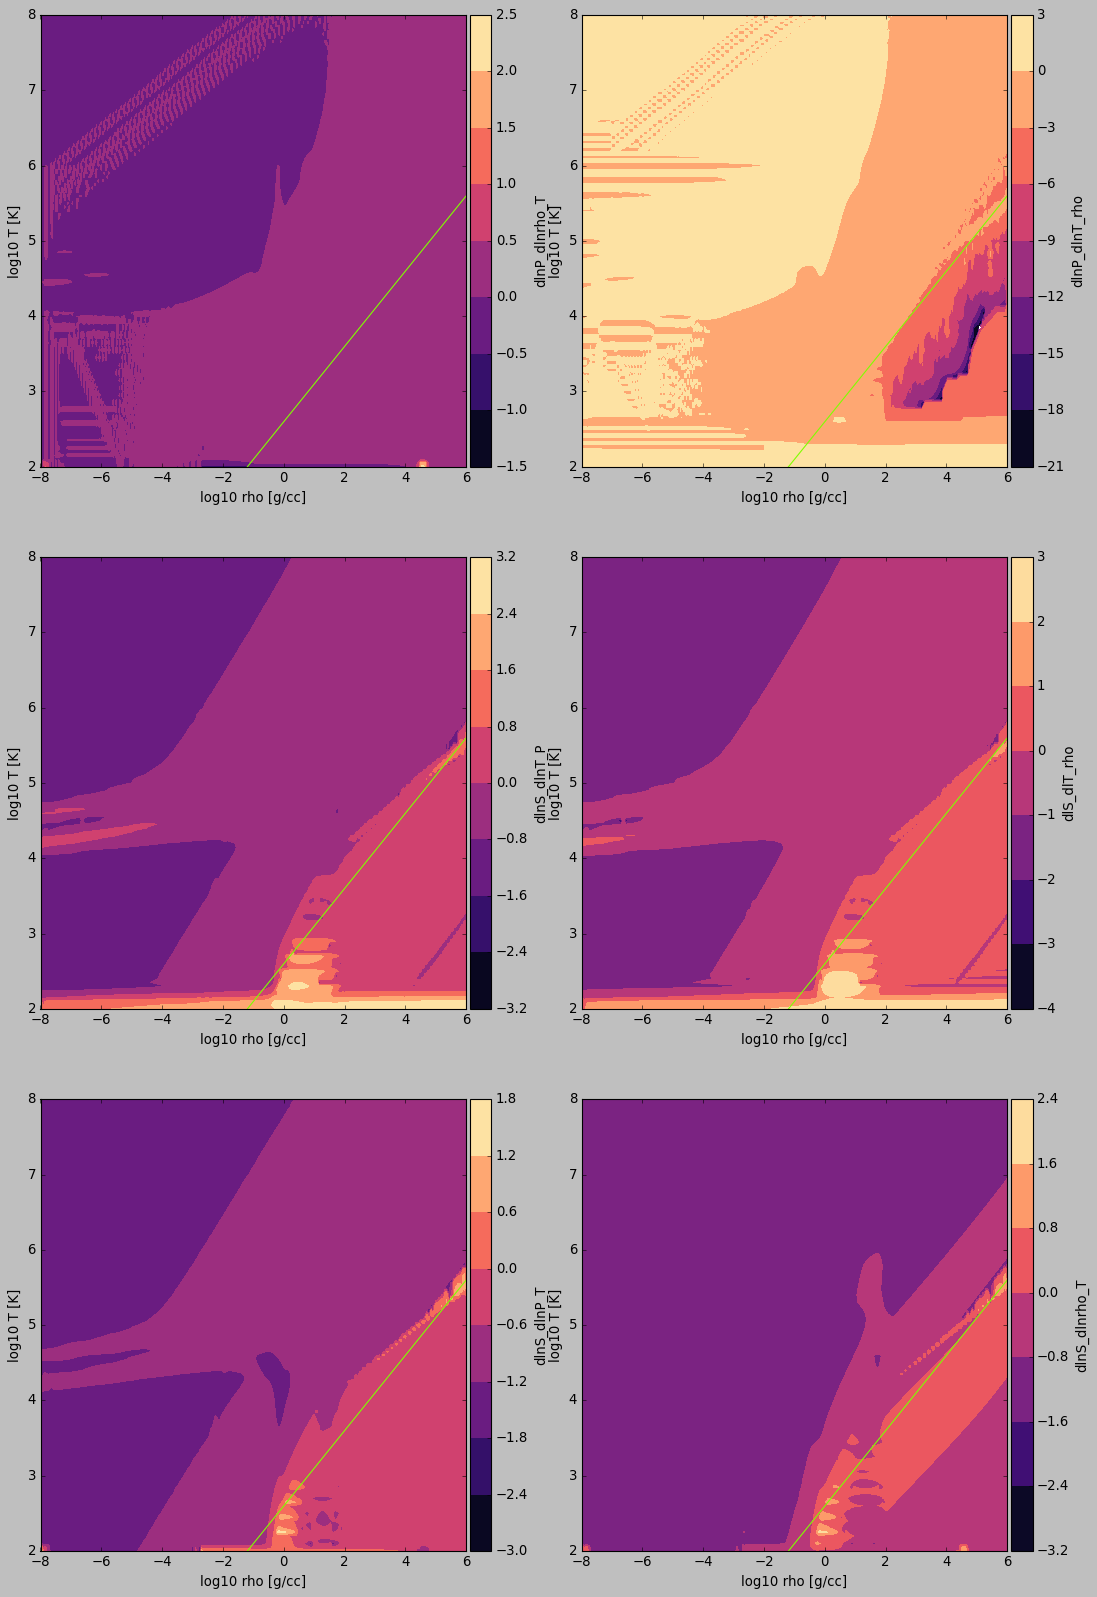

In [92]:
plot_finite_differences_for_negative_val_investigation(cms_He)

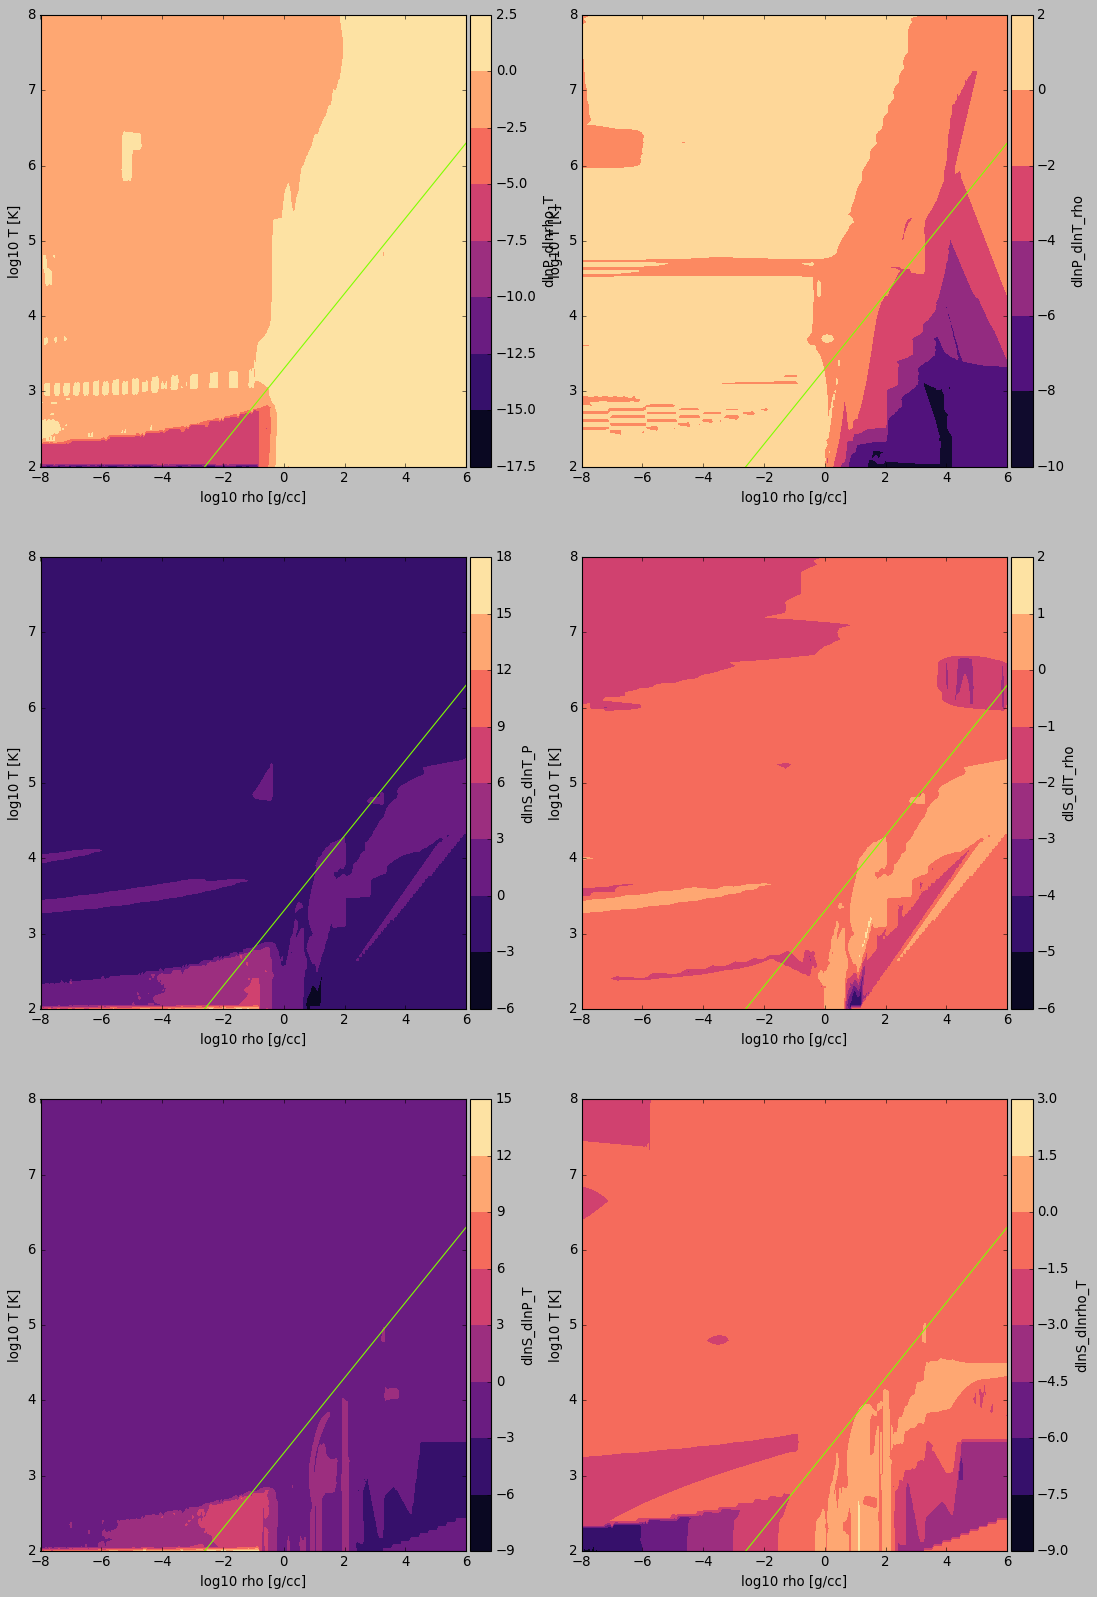

In [93]:
plot_finite_differences_for_negative_val_investigation(rock_water)